In [1]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import warnings

# ---------------------------
# 1. Load column names
# ---------------------------
def load_column_names(path):
    names = []
    with open(path, "r") as f:
        for line in f:
            if line.startswith("Column"):
                col_name = line.split(" ", 2)[-1].split(";")[0].strip()
                names.append(col_name)
    return names

# ---------------------------
# 2. Parse label legend
# ---------------------------
def parse_label_legend(path):
    legend = {}
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("Unique"):
                continue
            parts = re.split(r"\s*-\s*", line)
            if len(parts) == 3:
                idx, track, label = parts
                idx = int(idx.strip())
                track = track.strip()
                label = label.strip()
                if track not in legend:
                    legend[track] = {}
                legend[track][idx] = label
    return legend

# ---------------------------
# 3. Load .dat file
# ---------------------------
def load_dat_file(file_path, col_names):
    df = pd.read_csv(file_path, delimiter=" ", header=None)
    df.columns = col_names[:df.shape[1]]
    return df

# ---------------------------
# 4. Split columns by modality
# ---------------------------
def split_modalities(df):
    modalities = {}
    acc_cols = [c for c in df.columns if "Accelerometer" in c]
    imu_cols = [c for c in df.columns if "InertialMeasurementUnit" in c]
    loc_cols = [c for c in df.columns if "LOCATION" in c]
    reed_cols = [c for c in df.columns if "REED SWITCH" in c]

    if acc_cols: modalities['accelerometers'] = df[acc_cols].values
    if imu_cols: modalities['IMU'] = df[imu_cols].values
    if loc_cols: modalities['locations'] = df[loc_cols].values
    if reed_cols: modalities['reed_switches'] = df[reed_cols].values

    return modalities

# ---------------------------
# 5. Sliding windows (multi-modal)
# ---------------------------
def create_windows_multimodal(modalities_dict, labels_dict, window_size=100, stride=50):
    X_modalities = {mod: [] for mod in modalities_dict.keys()}
    y = []
    n_samples = len(next(iter(modalities_dict.values())))
    label_keys = list(labels_dict.keys())
    
    for start in range(0, n_samples - window_size + 1, stride):
        end = start + window_size
        for mod, data in modalities_dict.items():
            X_modalities[mod].append(data[start:end])
        # Assign label at window end
        y.append([labels_dict[k][end-1] for k in label_keys])

    X_modalities = {mod: np.array(arr) for mod, arr in X_modalities.items()}
    y = np.array(y)
    return X_modalities, y

# ---------------------------
# 6. Decode numeric labels (robust)
# ---------------------------
def decode_labels_numeric(y_array, legend, label_keys):
    decoded = []
    for row in y_array:
        row_dict = {}
        for key, val in zip(label_keys, row):
            track_dict = legend.get(key)
            if isinstance(track_dict, dict):
                row_dict[key] = track_dict.get(int(val), "Unknown")
            else:
                row_dict[key] = "Unknown"
        decoded.append(row_dict)
    return decoded

# ---------------------------
# 7. Filter rare classes
# ---------------------------
def filter_rare_classes(y_array, label_tracks, min_samples=10):
    """
    Filter out classes that have fewer than min_samples
    """
    y_filtered = y_array.copy()
    
    for i, task in enumerate(label_tracks):
        counts = Counter(y_array[:, i])
        rare_classes = [cls for cls, count in counts.items() if count < min_samples]
        
        if rare_classes:
            print(f"Filtering rare classes in {task}: {rare_classes}")
            # Replace rare classes with 0 (Unknown/Other)
            mask = np.isin(y_filtered[:, i], rare_classes)
            y_filtered[mask, i] = 0
    
    return y_filtered

# ---------------------------
# 8. Improved stratified split for multi-label
# ---------------------------
def stratified_multilabel_split(X_dict, y_array, test_size=0.3, random_state=42):
    """
    Create a more balanced split for multi-label data by considering
    the most important/balanced label for stratification
    """
    n_samples = y_array.shape[0]
    
    # Find the label column with best balance for stratification
    best_col = 0
    best_entropy = 0
    
    for i in range(y_array.shape[1]):
        counts = Counter(y_array[:, i])
        # Calculate normalized entropy as a measure of balance
        total = sum(counts.values())
        probs = [count/total for count in counts.values()]
        entropy = -sum(p * np.log2(p + 1e-10) for p in probs)
        normalized_entropy = entropy / np.log2(len(counts))
        
        if normalized_entropy > best_entropy:
            best_entropy = normalized_entropy
            best_col = i
    
    print(f"Using column {best_col} for stratification (entropy: {best_entropy:.3f})")
    
    # Create stratified split
    indices = np.arange(n_samples)
    try:
        train_idx, test_idx = train_test_split(
            indices, 
            test_size=test_size, 
            random_state=random_state,
            stratify=y_array[:, best_col]
        )
    except ValueError as e:
        print(f"Stratification failed: {e}")
        print("Falling back to random split...")
        train_idx, test_idx = train_test_split(
            indices, 
            test_size=test_size, 
            random_state=random_state
        )
    
    # Split the data
    X_train = {mod: X_dict[mod][train_idx] for mod in X_dict}
    X_test = {mod: X_dict[mod][test_idx] for mod in X_dict}
    y_train = y_array[train_idx]
    y_test = y_array[test_idx]
    
    return X_train, X_test, y_train, y_test

# ---------------------------
# 9. Check class distribution balance
# ---------------------------
def check_class_balance(y_train, y_test, label_tracks):
    """
    Check if classes are reasonably balanced between train and test sets
    """
    print("\n=== Class Distribution Check ===")
    
    for i, task in enumerate(label_tracks):
        train_counts = Counter(y_train[:, i])
        test_counts = Counter(y_test[:, i])
        
        all_classes = set(train_counts.keys()) | set(test_counts.keys())
        train_only = set(train_counts.keys()) - set(test_counts.keys())
        test_only = set(test_counts.keys()) - set(train_counts.keys())
        
        print(f"\n--- {task} ---")
        print(f"Total unique classes: {len(all_classes)}")
        print(f"Classes only in train: {len(train_only)} {list(train_only) if train_only else ''}")
        print(f"Classes only in test: {len(test_only)} {list(test_only) if test_only else ''}")
        
        # Show distribution for common classes
        common_classes = set(train_counts.keys()) & set(test_counts.keys())
        print(f"Classes in both: {len(common_classes)}")

# ---------------------------
# 10. Full preprocessing with improved splitting
# ---------------------------
def preprocess_opportunity_multimodal_balanced(dataset_folder,
                                               target_labels=None,
                                               window_size=100,
                                               stride=50,
                                               test_size=0.3,
                                               random_state=42,
                                               min_samples_per_class=10,
                                               filter_rare=True):
    if target_labels is None:
        target_labels = [
            "Locomotion", "HL_Activity", "LL_Left_Arm",
            "LL_Left_Arm_Object", "LL_Right_Arm",
            "LL_Right_Arm_Object", "ML_Both_Arms"
        ]

    col_names = load_column_names(os.path.join(dataset_folder, "column_names.txt"))
    legend = parse_label_legend(os.path.join(dataset_folder, "label_legend.txt"))

    X_mod_windows = {mod: [] for mod in ['accelerometers','IMU','locations','reed_switches']}
    y_windows = []

    files = [f for f in os.listdir(dataset_folder) if f.endswith(".dat")]
    
    for fname in files:
        df = load_dat_file(os.path.join(dataset_folder, fname), col_names)
        modalities = split_modalities(df)
        labels_dict = {track: df[track].values for track in target_labels}

        # Replace NaNs/Infs and scale
        for mod, arr in modalities.items():
            arr = np.nan_to_num(arr)
            modalities[mod] = StandardScaler().fit_transform(arr)

        # Sliding windows
        X_w, y_w = create_windows_multimodal(modalities, labels_dict, window_size, stride)
        for mod in X_w:
            X_mod_windows[mod].append(X_w[mod])
        y_windows.append(y_w)

    # Concatenate windows per modality
    X_mod_windows = {mod: np.concatenate(arr_list, axis=0) 
                     for mod, arr_list in X_mod_windows.items() if arr_list}
    y_windows = np.concatenate(y_windows, axis=0)

    print(f"Original data shape: {y_windows.shape}")
    
    # Filter rare classes if requested
    if filter_rare:
        y_windows = filter_rare_classes(y_windows, target_labels, min_samples_per_class)

    # Improved train/test split
    X_train_mod, X_test_mod, y_train, y_test = stratified_multilabel_split(
        X_mod_windows, y_windows, test_size, random_state
    )

    # Check class balance
    check_class_balance(y_train, y_test, target_labels)

    # Decode a few labels for verification
    decoded_example = decode_labels_numeric(y_train[:5], legend, target_labels)
    print(f"\nDecoded labels (sample): {decoded_example}")

    return (X_train_mod, y_train), (X_test_mod, y_test), legend, target_labels

# ---------------------------
# 11. Utility function to get balanced label distributions
# ---------------------------
def get_label_distributions_comparison(y_train, y_test, label_tracks):
    """
    Compare label distributions between train and test sets
    """
    print("\n=== Label Distribution Comparison ===")
    
    for i, task in enumerate(label_tracks):
        print(f"\n--- {task} ---")
        
        train_counts = Counter(y_train[:, i])
        test_counts = Counter(y_test[:, i])
        
        all_classes = sorted(set(train_counts.keys()) | set(test_counts.keys()))
        
        print(f"{'Class':<8} {'Train Count':<12} {'Train %':<10} {'Test Count':<11} {'Test %':<10}")
        print("-" * 60)
        
        train_total = len(y_train)
        test_total = len(y_test)
        
        for cls in all_classes:
            train_count = train_counts.get(cls, 0)
            test_count = test_counts.get(cls, 0)
            train_pct = (train_count / train_total) * 100
            test_pct = (test_count / test_total) * 100
            
            print(f"{cls:<8} {train_count:<12} {train_pct:<10.2f} {test_count:<11} {test_pct:<10.2f}")

# ---------------------------
# Example usage
# ---------------------------
# Usage example for your main code
if __name__ == "__main__":
    dataset_folder = "/kaggle/input/opportunity-activity-recognition/OpportunityUCIDataset/dataset"
    (train_X_mod, train_y), (test_X_mod, test_y), legend, label_tracks = preprocess_opportunity_multimodal_balanced(
        dataset_folder=dataset_folder,
        window_size=100,
        stride=50,
        test_size=0.3,
        min_samples_per_class=100,
        filter_rare=True
    )
    
    # Summary
    print(f"\nLabel tracks: {label_tracks}")
    for mod in train_X_mod:
        print(f"Train {mod}: {train_X_mod[mod].shape}")
    print(f"Train labels: {train_y.shape}")
    print(f"Test labels: {test_y.shape}")
    
    # Show detailed comparison
    get_label_distributions_comparison(train_y, test_y, label_tracks)

Original data shape: (17350, 7)
Filtering rare classes in LL_Left_Arm: [201, 203, 209, 208, 207, 210]
Filtering rare classes in LL_Left_Arm_Object: [319, 311, 308, 316, 307, 306, 310, 312, 322, 309, 323, 315, 317]
Filtering rare classes in LL_Right_Arm: [401, 403, 402, 409]
Filtering rare classes in LL_Right_Arm_Object: [515, 523]
Using column 1 for stratification (entropy: 0.890)

=== Class Distribution Check ===

--- Locomotion ---
Total unique classes: 5
Classes only in train: 0 
Classes only in test: 0 
Classes in both: 5

--- HL_Activity ---
Total unique classes: 6
Classes only in train: 0 
Classes only in test: 0 
Classes in both: 6

--- LL_Left_Arm ---
Total unique classes: 6
Classes only in train: 0 
Classes only in test: 0 
Classes in both: 6

--- LL_Left_Arm_Object ---
Total unique classes: 11
Classes only in train: 0 
Classes only in test: 0 
Classes in both: 11

--- LL_Right_Arm ---
Total unique classes: 10
Classes only in train: 0 
Classes only in test: 0 
Classes in both:

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import psutil
import time
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass
from abc import ABC, abstractmethod
import numpy as np

# ---------------------------
# Resource Monitor (Enhanced)
# ---------------------------
@dataclass
class ResourceMetrics:
    cpu_percent: float
    memory_percent: float
    inference_latency: float
    power_level: float  # 0.0-1.0 (estimated battery level)
    temperature: Optional[float] = None
    network_bandwidth: Optional[float] = None  # MB/s available bandwidth

class EnhancedResourceMonitor:
    def __init__(self, history_size=15):
        self.history_size = history_size
        self.latency_history = []
        self.cpu_history = []
        self.memory_history = []
        self.power_history = []
    
    def get_current_metrics(self) -> ResourceMetrics:
        cpu_percent = psutil.cpu_percent(interval=0.1)
        memory = psutil.virtual_memory()
        
        # Enhanced power estimation with history
        self.power_history.append(max(0.1, 1.0 - (cpu_percent / 100.0) * 0.6))
        if len(self.power_history) > self.history_size:
            self.power_history.pop(0)
        
        avg_power = sum(self.power_history) / len(self.power_history)
        avg_latency = sum(self.latency_history[-7:]) / max(1, len(self.latency_history[-7:]))
        
        return ResourceMetrics(
            cpu_percent=cpu_percent,
            memory_percent=memory.percent,
            inference_latency=avg_latency,
            power_level=avg_power
        )
    
    def update_latency(self, latency: float):
        self.latency_history.append(latency)
        if len(self.latency_history) > self.history_size:
            self.latency_history.pop(0)

# ---------------------------
# Module Efficiency Controller
# ---------------------------
class ModuleEfficiencyController:
    def __init__(self, target_latency_ms=120, efficiency_modes=4):
        self.target_latency_ms = target_latency_ms
        self.efficiency_modes = efficiency_modes  # 0: Full, 1: High, 2: Medium, 3: Low
        self.current_mode = 1
        self.mode_thresholds = [0.2, 0.4, 0.7, 0.9]  # Resource pressure thresholds
        
    def calculate_efficiency_mode(self, metrics: ResourceMetrics) -> int:
        """Calculate target efficiency mode based on resource constraints"""
        
        # Multi-factor resource pressure calculation
        cpu_pressure = min(1.0, metrics.cpu_percent / 85.0)
        memory_pressure = min(1.0, metrics.memory_percent / 90.0)
        latency_pressure = max(0.0, (metrics.inference_latency - self.target_latency_ms) / self.target_latency_ms)
        power_pressure = 1.0 - metrics.power_level
        
        # Weighted resource pressure
        total_pressure = (
            0.25 * cpu_pressure + 
            0.25 * memory_pressure + 
            0.35 * latency_pressure + 
            0.15 * power_pressure
        )
        
        # Map to efficiency mode
        for mode, threshold in enumerate(self.mode_thresholds):
            if total_pressure <= threshold:
                self.current_mode = mode
                break
        else:
            self.current_mode = self.efficiency_modes - 1
        
        return self.current_mode

# ---------------------------
# Adaptive Depthwise Separable Convolution
# ---------------------------
class AdaptiveDepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # Create layers with full channel capacity
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size, 
                                 stride=stride, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv1d(in_channels, out_channels, 1)
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU6(inplace=True)
        
        # Efficiency mode configurations
        self.efficiency_configs = {
            0: {'active_channels_ratio': 1.0, 'use_bn': True},    # Full
            1: {'active_channels_ratio': 0.8, 'use_bn': True},    # High
            2: {'active_channels_ratio': 0.6, 'use_bn': False},   # Medium
            3: {'active_channels_ratio': 0.4, 'use_bn': False},   # Low
        }
        self.current_mode = 1
        
    def set_efficiency_mode(self, mode: int):
        self.current_mode = mode
        
    def forward(self, x):
        # CRITICAL FIX: Ensure input channels match what the layer expects
        if x.size(1) != self.in_channels:
            if x.size(1) > self.in_channels:
                # Truncate excess channels
                x = x[:, :self.in_channels, :]
                print(f"Warning: Truncated input from {x.size(1)} to {self.in_channels} channels")
            else:
                # Pad with zeros if we have fewer channels
                padding_size = self.in_channels - x.size(1)
                padding = torch.zeros(x.size(0), padding_size, x.size(2), 
                                    device=x.device, dtype=x.dtype)
                x = torch.cat([x, padding], dim=1)
                print(f"Warning: Padded input from {x.size(1)} to {self.in_channels} channels")
        
        config = self.efficiency_configs[self.current_mode]
        
        # Apply efficiency-based channel masking AFTER ensuring correct input size
        active_channels = int(self.in_channels * config['active_channels_ratio'])
        
        # Method: Zero out inactive channels (preserves conv layer compatibility)
        if active_channels < self.in_channels:
            # Create a mask that zeros out inactive channels
            mask = torch.ones_like(x)
            mask[:, active_channels:, :] = 0
            x = x * mask
        
        # Now we can safely use the conv layers
        out = self.depthwise(x)
        
        # FIXED: Apply BatchNorm to FULL tensor, not just active channels
        if config['use_bn']:
            out = self.bn1(out)  # Apply to ALL channels (including masked ones)
        out = self.relu(out)
        
        out = self.pointwise(out)
        if config['use_bn']:
            out = self.bn2(out)
        out = self.relu(out)
        
        return out
        
# ---------------------------
# Modular Sensor Encoder
# ---------------------------
class ModularSensorEncoder(nn.Module):
    def __init__(self, input_dim, output_dim=32, encoder_type="hybrid"):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.encoder_type = encoder_type
        self.current_mode = 1
        
        # Multiple encoding pathways for different efficiency modes
        if encoder_type == "hybrid":
            # Full complexity path (mode 0, 1)
            self.conv_path = nn.Sequential(
                AdaptiveDepthwiseSeparableConv(input_dim, output_dim*2),
                AdaptiveDepthwiseSeparableConv(output_dim*2, output_dim),
                nn.AdaptiveAvgPool1d(1)
            )
            
            # Medium complexity path (mode 2)
            self.linear_path = nn.Sequential(
                nn.Linear(input_dim, output_dim*2),
                nn.ReLU6(),
                nn.Dropout(0.1),
                nn.Linear(output_dim*2, output_dim)
            )
            
            # Low complexity path (mode 3)
            self.simple_path = nn.Linear(input_dim, output_dim)
            
        else:  # "linear" type for small input dimensions
            self.linear_path = nn.Sequential(
                nn.Linear(input_dim, max(16, output_dim*2)),
                nn.ReLU6(),
                nn.Linear(max(16, output_dim*2), output_dim)
            )
            self.simple_path = nn.Linear(input_dim, output_dim)
    
    def set_efficiency_mode(self, mode: int):
        self.current_mode = mode
        if hasattr(self, 'conv_path'):
            for layer in self.conv_path:
                if isinstance(layer, AdaptiveDepthwiseSeparableConv):
                    layer.set_efficiency_mode(mode)
    
    def forward(self, x):
        # Input shape handling
        if x.dim() == 2:  # (batch, features)
            x = x.unsqueeze(-1)  # (batch, features, 1)
        elif x.dim() == 3 and x.size(-1) > 1:  # (batch, seq_len, features)
            x = x.transpose(1, 2)  # (batch, features, seq_len)
        
        # Route through different paths based on efficiency mode
        if self.encoder_type == "hybrid":
            if self.current_mode <= 1 and hasattr(self, 'conv_path'):
                out = self.conv_path(x).squeeze(-1)
            elif self.current_mode == 2:
                if x.dim() == 3:
                    x = x.mean(dim=-1)  # Global average pooling
                out = self.linear_path(x)
            else:  # mode 3
                if x.dim() == 3:
                    x = x.mean(dim=-1)
                out = self.simple_path(x)
        else:  # linear encoder
            if x.dim() == 3:
                x = x.mean(dim=-1)
            if self.current_mode <= 2:
                out = self.linear_path(x)
            else:
                out = self.simple_path(x)
        
        return out

# ---------------------------
# Multi-Head Cross-Modal Fusion with Gating
# ---------------------------
class GatedMultiModalFusion(nn.Module):
    def __init__(self, feature_dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.feature_dim = feature_dim
        self.num_heads = num_heads
        self.head_dim = feature_dim // num_heads
        self.scale = math.sqrt(self.head_dim)
        self.current_mode = 1
        
        # Multi-head attention components
        self.q_linear = nn.Linear(feature_dim, feature_dim)
        self.k_linear = nn.Linear(feature_dim, feature_dim)
        self.v_linear = nn.Linear(feature_dim, feature_dim)
        self.out_linear = nn.Linear(feature_dim, feature_dim)
        
        # Gating mechanism for modality importance
        self.gate_network = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 2),
            nn.ReLU(),
            nn.Linear(feature_dim // 2, 1),
            nn.Sigmoid()
        )
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(feature_dim)
        
        # Efficiency configurations
        self.mode_configs = {
            0: {'active_heads': num_heads, 'use_attention': True, 'use_gating': True},
            1: {'active_heads': max(4, num_heads//2), 'use_attention': True, 'use_gating': True},
            2: {'active_heads': 2, 'use_attention': True, 'use_gating': False},
            3: {'active_heads': 1, 'use_attention': False, 'use_gating': False},
        }
    
    def set_efficiency_mode(self, mode: int):
        self.current_mode = mode
    
    def forward(self, modality_features: List[torch.Tensor]):
        if len(modality_features) == 0:
            return torch.zeros(1, self.feature_dim, device=modality_features[0].device if modality_features else 'cpu')
        
        if len(modality_features) == 1:
            return modality_features[0]
        
        config = self.mode_configs[self.current_mode]
        
        # Stack modality features
        x = torch.stack(modality_features, dim=1)  # (batch, n_modalities, feature_dim)
        batch_size, n_modalities, actual_feature_dim = x.shape
        
        # Handle feature dimension mismatch
        if actual_feature_dim != self.feature_dim:
            # Project to expected dimension
            if not hasattr(self, 'feature_adapter'):
                self.feature_adapter = nn.Linear(actual_feature_dim, self.feature_dim).to(x.device)
            x = self.feature_adapter(x)
        
        if not config['use_attention']:
            # Simple averaging for lowest efficiency mode
            if config['use_gating']:
                gates = []
                for i in range(n_modalities):
                    gate = self.gate_network(x[:, i, :])  # (batch, 1)
                    gates.append(gate)
                gates = torch.cat(gates, dim=1).unsqueeze(-1)  # (batch, n_modalities, 1)
                weighted_x = x * gates
                return weighted_x.sum(dim=1) / (gates.sum(dim=1) + 1e-8)
            else:
                return x.mean(dim=1)
        
        # Multi-head attention fusion
        active_heads = min(config['active_heads'], self.num_heads)
        effective_head_dim = self.feature_dim // active_heads
        
        # Apply linear transformations
        Q = self.q_linear(x)  # (batch, n_modalities, feature_dim)
        K = self.k_linear(x)  # (batch, n_modalities, feature_dim)
        V = self.v_linear(x)  # (batch, n_modalities, feature_dim)
        
        # Handle case where we use fewer heads than initialized
        if active_heads < self.num_heads:
            # Use only the first portion of the output for active heads
            projection_dim = active_heads * effective_head_dim
            Q = Q[..., :projection_dim]
            K = K[..., :projection_dim]
            V = V[..., :projection_dim]
        else:
            projection_dim = self.feature_dim
            effective_head_dim = self.head_dim
        
        # Reshape for multi-head attention
        Q = Q.view(batch_size, n_modalities, active_heads, effective_head_dim).transpose(1, 2)
        K = K.view(batch_size, n_modalities, active_heads, effective_head_dim).transpose(1, 2)
        V = V.view(batch_size, n_modalities, active_heads, effective_head_dim).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(effective_head_dim)
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        attn_output = torch.matmul(attn_weights, V)
        attn_output = attn_output.transpose(1, 2).contiguous().view(
            batch_size, n_modalities, active_heads * effective_head_dim
        )
        
        # Project back to feature_dim if using fewer heads
        if active_heads < self.num_heads or (active_heads * effective_head_dim) != self.feature_dim:
            current_dim = active_heads * effective_head_dim
            if not hasattr(self, 'head_adapter') or self.head_adapter.in_features != current_dim:
                self.head_adapter = nn.Linear(current_dim, self.feature_dim).to(attn_output.device)
            attn_output = self.head_adapter(attn_output)
        
        fused = self.out_linear(attn_output)
        
        # Gating mechanism
        if config['use_gating']:
            gates = []
            for i in range(n_modalities):
                gate = self.gate_network(fused[:, i, :])
                gates.append(gate)
            gates = torch.cat(gates, dim=1).unsqueeze(-1)
            fused = fused * gates
            
            # Global fusion with gating normalization
            output = fused.sum(dim=1) / (gates.sum(dim=1) + 1e-8)
        else:
            # Simple averaging
            output = fused.mean(dim=1)
        
        return self.layer_norm(output)
        
# ---------------------------
# Online Learning Head with Memory Bank
# ---------------------------
class OnlineLearningHead(nn.Module):
    def __init__(self, input_dim, task_configs: Dict[str, int], memory_size=1000):
        super().__init__()
        self.input_dim = input_dim
        self.task_configs = task_configs
        self.memory_size = memory_size
        self.current_mode = 1
        
        # Shared feature extractor
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU6(),
            nn.BatchNorm1d(input_dim // 2),
            nn.Dropout(0.15),
            nn.Linear(input_dim // 2, input_dim // 4)
        )
        
        # Task-specific heads
        self.task_heads = nn.ModuleDict()
        for task_name, num_classes in task_configs.items():
            self.task_heads[task_name] = nn.Sequential(
                nn.Linear(input_dim // 4, max(8, num_classes * 2)),
                nn.ReLU6(),
                nn.Linear(max(8, num_classes * 2), num_classes)
            )
        
        # Memory bank for continual learning
        self.register_buffer('memory_features', torch.zeros(memory_size, input_dim))
        self.register_buffer('memory_labels', torch.full((memory_size,), -1, dtype=torch.long))
        self.register_buffer('memory_tasks', torch.full((memory_size,), -1, dtype=torch.long))
        self.memory_ptr = 0
        self.memory_filled = False
        
        # Task importance tracking
        self.task_importance = {task: 1.0 for task in task_configs.keys()}
        self.active_tasks = list(task_configs.keys())
        
        # Efficiency modes
        self.mode_configs = {
            0: {'use_shared': True, 'use_dropout': True, 'use_memory': True},
            1: {'use_shared': True, 'use_dropout': True, 'use_memory': True},
            2: {'use_shared': True, 'use_dropout': False, 'use_memory': False},
            3: {'use_shared': False, 'use_dropout': False, 'use_memory': False},
        }
    
    def set_efficiency_mode(self, mode: int):
        self.current_mode = mode
        config = self.mode_configs[mode]
        
        # Adjust active tasks based on importance
        if mode >= 2:
            sorted_tasks = sorted(self.task_configs.keys(), 
                                key=lambda t: self.task_importance[t], reverse=True)
            max_tasks = 2 if mode == 2 else 1
            self.active_tasks = sorted_tasks[:max_tasks]
        else:
            self.active_tasks = list(self.task_configs.keys())
    
    def update_memory(self, features: torch.Tensor, labels: Dict[str, torch.Tensor]):
        """Update memory bank with new samples"""
        if self.current_mode <= 1:  # Only use memory in high-efficiency modes
            batch_size = features.size(0)
            for i in range(batch_size):
                # Simple round-robin memory update
                self.memory_features[self.memory_ptr] = features[i].detach()
                # Store first available label (simplified)
                for task_idx, (task_name, task_labels) in enumerate(labels.items()):
                    if task_labels[i] >= 0:  # Valid label
                        self.memory_labels[self.memory_ptr] = task_labels[i]
                        self.memory_tasks[self.memory_ptr] = task_idx
                        break
                
                self.memory_ptr = (self.memory_ptr + 1) % self.memory_size
                if self.memory_ptr == 0:
                    self.memory_filled = True
    
    def get_memory_samples(self, num_samples: int = 32):
        """Retrieve samples from memory for replay"""
        if not self.mode_configs[self.current_mode]['use_memory'] or not self.memory_filled:
            return None, None
        
        max_idx = self.memory_size if self.memory_filled else self.memory_ptr
        if max_idx == 0:
            return None, None
            
        indices = torch.randint(0, max_idx, (min(num_samples, max_idx),))
        return self.memory_features[indices], self.memory_labels[indices]
    
    def forward(self, x):
        config = self.mode_configs[self.current_mode]
        
        if config['use_shared']:
            # Use shared layers with potential dropout
            if config['use_dropout'] and self.training:
                shared_out = self.shared_layers(x)
            else:
                # Disable dropout for efficiency
                self.shared_layers.eval()
                with torch.no_grad():
                    shared_out = self.shared_layers(x)
                if self.training:
                    self.shared_layers.train()
        else:
            # Skip shared layers, use direct connection
            shared_out = x[:, :self.input_dim // 4]  # Simple dimension reduction
        
        # Compute outputs only for active tasks
        outputs = {}
        for task_name in self.active_tasks:
            if task_name in self.task_heads:
                outputs[task_name] = self.task_heads[task_name](shared_out)
        
        return outputs

# ---------------------------
# MELON: Main Architecture
# ---------------------------
class MELON(nn.Module):
    def __init__(self, modality_configs: Dict[str, int], task_configs: Dict[str, int],
                 feature_dim=64, target_latency_ms=120, memory_size=1000):
        super().__init__()
        
        self.modality_configs = modality_configs
        self.task_configs = task_configs
        self.feature_dim = feature_dim
        
        # Resource management
        self.resource_monitor = EnhancedResourceMonitor(history_size=20)
        self.efficiency_controller = ModuleEfficiencyController(
            target_latency_ms=target_latency_ms, efficiency_modes=4
        )
        
        # Modular encoders for different sensor types
        self.encoders = nn.ModuleDict()
        for mod_name, input_dim in modality_configs.items():
            encoder_type = "hybrid" if input_dim > 8 else "linear"
            self.encoders[mod_name] = ModularSensorEncoder(
                input_dim, output_dim=feature_dim, encoder_type=encoder_type
            )
        
        # Cross-modal fusion with gating
        self.fusion_module = GatedMultiModalFusion(
            feature_dim, num_heads=8, dropout=0.1
        )
        
        # Online learning head with memory
        self.learning_head = OnlineLearningHead(
            feature_dim, task_configs, memory_size=memory_size
        )
        
        # Global normalization
        self.global_norm = nn.LayerNorm(feature_dim)
        
        # Adaptation tracking
        self.inference_count = 0
        self.adaptation_interval = 15  # Adapt every N inferences
        self.current_efficiency_mode = 1
        
        # Performance logging
        self.performance_log = {
            'mode_history': [],
            'latency_history': [],
            'accuracy_history': []
        }
    
    def set_efficiency_mode(self, mode: int):
        """Manually set efficiency mode for all components"""
        self.current_efficiency_mode = mode
        
        for encoder in self.encoders.values():
            encoder.set_efficiency_mode(mode)
        
        self.fusion_module.set_efficiency_mode(mode)
        self.learning_head.set_efficiency_mode(mode)
        
        print(f"MELON efficiency mode set to: {mode}")
    
    def adapt_efficiency(self):
        """Automatically adapt efficiency based on resource constraints"""
        metrics = self.resource_monitor.get_current_metrics()
        target_mode = self.efficiency_controller.calculate_efficiency_mode(metrics)
        
        if target_mode != self.current_efficiency_mode:
            self.set_efficiency_mode(target_mode)
            
            # Log the adaptation
            self.performance_log['mode_history'].append({
                'inference_count': self.inference_count,
                'mode': target_mode,
                'metrics': metrics
            })
        
        return target_mode, metrics
    
    def forward(self, modality_data: Dict[str, torch.Tensor], 
                update_memory: bool = False, labels: Dict[str, torch.Tensor] = None):
        start_time = time.time()
        
        # Encode each modality
        encoded_features = []
        for mod_name, data in modality_data.items():
            if mod_name in self.encoders:
                features = self.encoders[mod_name](data)
                if features.dim() > 2:
                    features = features.flatten(1) 
                encoded_features.append(features)
        
        if not encoded_features:
            # Fallback if no valid modalities
            batch_size = next(iter(modality_data.values())).size(0)
            device = next(self.parameters()).device
            fused_features = torch.zeros(batch_size, self.feature_dim).to(device)
        else:
            # Cross-modal fusion
            fused_features = self.fusion_module(encoded_features)
            fused_features = self.global_norm(fused_features)
        
        # Classification
        task_outputs = self.learning_head(fused_features)
        
        # Update memory bank if training
        if update_memory and labels is not None and self.training:
            self.learning_head.update_memory(fused_features, labels)
        
        # Performance tracking
        inference_time = (time.time() - start_time) * 1000
        self.resource_monitor.update_latency(inference_time)
        
        # Periodic efficiency adaptation
        self.inference_count += 1
        if self.inference_count % self.adaptation_interval == 0:
            mode, metrics = self.adapt_efficiency()
            
            # Optional debug info
            if hasattr(self, '_debug') and self._debug:
                print(f"MELON adapted to mode {mode}, "
                      f"CPU: {metrics.cpu_percent:.1f}%, "
                      f"Latency: {metrics.inference_latency:.1f}ms, "
                      f"Power: {metrics.power_level:.2f}")
        
        return task_outputs
    
    # ---------------------------
    # Dynamic Class Management (similar to LightSpaN)
    # ---------------------------
    
    def resize_output_layers(self, new_task_configs: Dict[str, int]):
        """Dynamically resize task heads for new classes"""
        print(f"MELON: Resizing output layers from {self.task_configs} to {new_task_configs}")
        
        for task_name, new_num_classes in new_task_configs.items():
            if task_name in self.task_configs:
                current_num_classes = self.task_configs[task_name]
                
                if new_num_classes != current_num_classes:
                    # Recreate task head
                    input_dim = self.feature_dim // 4  # Based on shared_layers output
                    new_head = nn.Sequential(
                        nn.Linear(input_dim, max(8, new_num_classes * 2)),
                        nn.ReLU6(),
                        nn.Linear(max(8, new_num_classes * 2), new_num_classes)
                    )
                    
                    # Transfer weights if expanding
                    if new_num_classes > current_num_classes:
                        old_head = self.learning_head.task_heads[task_name]
                        with torch.no_grad():
                            # Copy first layer
                            new_head[0].weight.data[:old_head[0].weight.size(0), :] = old_head[0].weight.data
                            new_head[0].bias.data[:old_head[0].bias.size(0)] = old_head[0].bias.data
                            
                            # Copy second layer for existing classes
                            new_head[2].weight.data[:current_num_classes, :old_head[2].weight.size(1)] = old_head[2].weight.data
                            new_head[2].bias.data[:current_num_classes] = old_head[2].bias.data
                    
                    self.learning_head.task_heads[task_name] = new_head
                    print(f"  Resized {task_name}: {current_num_classes} -> {new_num_classes}")
            else:
                # New task
                input_dim = self.feature_dim // 4
                self.learning_head.task_heads[task_name] = nn.Sequential(
                    nn.Linear(input_dim, max(8, new_num_classes * 2)),
                    nn.ReLU6(),
                    nn.Linear(max(8, new_num_classes * 2), new_num_classes)
                )
                print(f"  Added new task {task_name} with {new_num_classes} classes")
        
        # Update configs
        self.task_configs = new_task_configs.copy()
        self.learning_head.task_configs = new_task_configs.copy()
        self.learning_head.task_importance = {task: 1.0 for task in new_task_configs.keys()}
        self.learning_head.active_tasks = list(new_task_configs.keys())
    
    def auto_detect_and_resize_classes(self, train_labels: Dict[str, torch.Tensor], use_class_count=True):
        """Auto-detect classes and resize (similar to LightSpaN)"""
        detected_classes = {}
        
        for task_name, labels in train_labels.items():
            unique_classes = torch.unique(labels[labels >= 0])
            max_class = int(unique_classes.max().item())
            
            if use_class_count:
                num_classes = len(unique_classes)
                print(f"MELON - Task '{task_name}': {len(unique_classes)} unique classes, max ID: {max_class}")
            else:
                num_classes = max_class + 1
                print(f"MELON - Task '{task_name}': using {num_classes} outputs (max_id + 1)")
            
            detected_classes[task_name] = num_classes
            print(f"  Unique classes: {unique_classes.tolist()}")
        
        # Store class mappings
        self.class_mappings = {}
        for task_name, labels in train_labels.items():
            unique_classes = torch.unique(labels[labels >= 0])
            self.class_mappings[task_name] = {
                int(class_id.item()): idx for idx, class_id in enumerate(unique_classes)
            }
        
        print(f"\nMELON class mappings:")
        for task_name, mapping in self.class_mappings.items():
            print(f"  {task_name}: {mapping}")
        
        if detected_classes != self.task_configs:
            self.resize_output_layers(detected_classes)
        
        return detected_classes
    
    def map_labels_to_indices(self, labels: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """Map class IDs to output indices"""
        if not hasattr(self, 'class_mappings'):
            raise ValueError("Class mappings not found. Run auto_detect_and_resize_classes() first.")
        
        mapped_labels = {}
        for task_name, task_labels in labels.items():
            if task_name not in self.class_mappings:
                mapped_labels[task_name] = task_labels
                continue
            
            mapping = self.class_mappings[task_name]
            mapped_task_labels = task_labels.clone()
            
            for original_id, new_index in mapping.items():
                mask = (task_labels == original_id)
                mapped_task_labels[mask] = new_index
            
            mapped_labels[task_name] = mapped_task_labels
        
        return mapped_labels
    
    def map_predictions_to_class_ids(self, predictions: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """Convert prediction indices back to original class IDs"""
        if not hasattr(self, 'class_mappings'):
            print("Warning: No class mappings found, returning original predictions")
            return predictions
        
        mapped_predictions = {}
        for task_name, task_preds in predictions.items():
            if task_name not in self.class_mappings:
                mapped_predictions[task_name] = task_preds
                continue
            
            mapping = self.class_mappings[task_name]
            reverse_mapping = {idx: original_id for original_id, idx in mapping.items()}
            
            mapped_task_preds = task_preds.clone()
            for index, original_id in reverse_mapping.items():
                mask = (task_preds == index)
                mapped_task_preds[mask] = original_id
            
            mapped_predictions[task_name] = mapped_task_preds
        
        return mapped_predictions
    
    def get_memory_replay_batch(self, batch_size: int = 32):
        """Get a batch of samples from memory for experience replay"""
        return self.learning_head.get_memory_samples(batch_size)
    
    def update_task_importance(self, task_performance: Dict[str, float]):
        """Update task importance based on performance metrics"""
        for task_name, performance in task_performance.items():
            if task_name in self.learning_head.task_importance:
                # Exponential moving average update
                alpha = 0.1
                current_importance = self.learning_head.task_importance[task_name]
                self.learning_head.task_importance[task_name] = (
                    alpha * performance + (1 - alpha) * current_importance
                )
    
    def get_model_stats(self):
        """Get comprehensive model statistics"""
        total_params = sum(p.numel() for p in self.parameters())
        
        # Count trainable parameters
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        
        # Estimate active parameters based on efficiency mode
        efficiency_ratios = {0: 1.0, 1: 0.75, 2: 0.5, 3: 0.25}
        active_ratio = efficiency_ratios.get(self.current_efficiency_mode, 0.75)
        estimated_active_params = int(trainable_params * active_ratio)
        
        # Get memory usage
        memory_used = len([i for i in self.learning_head.memory_labels if i >= 0])
        memory_utilization = memory_used / self.learning_head.memory_size
        
        stats = {
            'architecture': 'MELON',
            'total_params': total_params,
            'trainable_params': trainable_params,
            'estimated_active_params': estimated_active_params,
            'efficiency_mode': self.current_efficiency_mode,
            'active_tasks': self.learning_head.active_tasks.copy(),
            'task_configs': self.task_configs.copy(),
            'feature_dim': self.feature_dim,
            'memory_utilization': memory_utilization,
            'memory_size': self.learning_head.memory_size,
            'inference_count': self.inference_count,
            'adaptation_interval': self.adaptation_interval,
            'fusion_heads': self.fusion_module.num_heads,
            'active_fusion_heads': self.fusion_module.mode_configs[self.current_efficiency_mode]['active_heads']
        }
        
        if hasattr(self, 'class_mappings'):
            stats['class_mappings'] = self.class_mappings.copy()
        
        # Add recent performance metrics
        if self.performance_log['mode_history']:
            stats['recent_adaptations'] = self.performance_log['mode_history'][-5:]
        
        return stats
    
    def enable_continual_learning_mode(self):
        """Enable features specifically for continual learning"""
        # Reduce adaptation interval for more responsive efficiency changes
        self.adaptation_interval = 8
        
        # Enable memory usage in lower efficiency modes
        for mode in [2, 3]:
            self.learning_head.mode_configs[mode]['use_memory'] = True
        
        # Set flag for continual learning specific behaviors
        self._continual_learning_mode = True
        print("MELON: Continual learning mode enabled")
    
    def get_modality_importance(self):
        """Analyze which modalities are most important for current tasks"""
        importance_scores = {}
        
        # Simple gradient-based importance (would need to be called during training)
        for mod_name, encoder in self.encoders.items():
            total_grad_norm = 0.0
            param_count = 0
            
            for param in encoder.parameters():
                if param.grad is not None:
                    total_grad_norm += param.grad.norm().item()
                    param_count += 1
            
            if param_count > 0:
                importance_scores[mod_name] = total_grad_norm / param_count
            else:
                importance_scores[mod_name] = 0.0
        
        return importance_scores
    
    def save_checkpoint(self, filepath: str):
        """Save model checkpoint with additional MELON-specific info"""
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'task_configs': self.task_configs,
            'modality_configs': self.modality_configs,
            'feature_dim': self.feature_dim,
            'current_efficiency_mode': self.current_efficiency_mode,
            'inference_count': self.inference_count,
            'performance_log': self.performance_log,
            'task_importance': self.learning_head.task_importance,
        }
        
        if hasattr(self, 'class_mappings'):
            checkpoint['class_mappings'] = self.class_mappings
        
        torch.save(checkpoint, filepath)
        print(f"MELON checkpoint saved to {filepath}")
    
    def load_checkpoint(self, filepath: str):
        """Load model checkpoint and restore MELON-specific info"""
        checkpoint = torch.load(filepath, map_location='cpu')
        
        self.load_state_dict(checkpoint['model_state_dict'])
        self.task_configs = checkpoint['task_configs']
        self.modality_configs = checkpoint['modality_configs']
        self.current_efficiency_mode = checkpoint.get('current_efficiency_mode', 1)
        self.inference_count = checkpoint.get('inference_count', 0)
        self.performance_log = checkpoint.get('performance_log', {'mode_history': [], 'latency_history': [], 'accuracy_history': []})
        
        if 'class_mappings' in checkpoint:
            self.class_mappings = checkpoint['class_mappings']
        
        if 'task_importance' in checkpoint:
            self.learning_head.task_importance = checkpoint['task_importance']
        
        # Set efficiency mode for all components
        self.set_efficiency_mode(self.current_efficiency_mode)
        
        print(f"MELON checkpoint loaded from {filepath}")
        print(f"  Restored to efficiency mode: {self.current_efficiency_mode}")
        print(f"  Inference count: {self.inference_count}")

# ---------------------------
# MELON Trainer (Specialized for Online Learning)
# ---------------------------
class MELONTrainer:
    def __init__(self, model: MELON, learning_rate=0.001, weight_decay=1e-4, 
                 memory_replay_ratio=0.3, task_balancing=True):
        self.model = model
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=1000, eta_min=1e-6)
        
        self.memory_replay_ratio = memory_replay_ratio
        self.task_balancing = task_balancing
        
        # Loss functions
        self.criterion = nn.CrossEntropyLoss(ignore_index=-1)  # Ignore missing labels
        
        # Training statistics
        self.training_stats = {
            'total_batches': 0,
            'memory_replays': 0,
            'task_losses': {},
            'efficiency_mode_usage': {0: 0, 1: 0, 2: 0, 3: 0}
        }
    
    def train_batch(self, modality_data: Dict[str, torch.Tensor], 
                   labels: Dict[str, torch.Tensor], use_memory_replay: bool = True):
        """Train on a single batch with optional memory replay"""
        self.model.train()
        self.optimizer.zero_grad()
        
        # Map labels to indices
        mapped_labels = self.model.map_labels_to_indices(labels)
        
        # Forward pass
        outputs = self.model(modality_data, update_memory=True, labels=mapped_labels)
        
        # Compute losses for each active task
        total_loss = 0.0
        task_losses = {}
        valid_tasks = 0
        
        for task_name, task_output in outputs.items():
            if task_name in mapped_labels:
                task_labels = mapped_labels[task_name]
                # Only compute loss for samples with valid labels (>= 0)
                valid_mask = task_labels >= 0
                if valid_mask.any():
                    task_loss = self.criterion(task_output[valid_mask], task_labels[valid_mask])
                    task_losses[task_name] = task_loss.item()
                    
                    # Task balancing
                    if self.task_balancing:
                        task_weight = 1.0 / len(outputs)  # Equal weighting
                        total_loss += task_weight * task_loss
                    else:
                        total_loss += task_loss
                    valid_tasks += 1
        
        # Memory replay (if enabled and memory is available)
        replay_loss = 0.0
        if use_memory_replay and self.memory_replay_ratio > 0:
            memory_features, memory_labels = self.model.get_memory_replay_batch(
                batch_size=int(modality_data[list(modality_data.keys())[0]].size(0) * self.memory_replay_ratio)
            )
            
            if memory_features is not None:
                memory_outputs = self.model.learning_head(memory_features)
                
                # Simplified replay loss (assumes single task for memory samples)
                if len(memory_outputs) > 0:
                    first_task = list(memory_outputs.keys())[0]
                    valid_memory_mask = memory_labels >= 0
                    if valid_memory_mask.any():
                        replay_loss = self.criterion(
                            memory_outputs[first_task][valid_memory_mask],
                            memory_labels[valid_memory_mask]
                        )
                        total_loss += 0.5 * replay_loss  # Reduced weight for replay
                        self.training_stats['memory_replays'] += 1
        
        # Backward pass
        if valid_tasks > 0:
            total_loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            self.scheduler.step()
        
        # Update statistics
        self.training_stats['total_batches'] += 1
        self.training_stats['efficiency_mode_usage'][self.model.current_efficiency_mode] += 1
        
        for task_name, loss_val in task_losses.items():
            if task_name not in self.training_stats['task_losses']:
                self.training_stats['task_losses'][task_name] = []
            self.training_stats['task_losses'][task_name].append(loss_val)
        
        return {
            'total_loss': total_loss.item() if valid_tasks > 0 else 0.0,
            'task_losses': task_losses,
            'replay_loss': replay_loss.item() if isinstance(replay_loss, torch.Tensor) else 0.0,
            'efficiency_mode': self.model.current_efficiency_mode,
            'valid_tasks': valid_tasks
        }
    
    def evaluate(self, modality_data: Dict[str, torch.Tensor], 
                labels: Dict[str, torch.Tensor]):
        """Evaluate model on given data"""
        self.model.eval()
        
        with torch.no_grad():
            # Map labels to indices
            mapped_labels = self.model.map_labels_to_indices(labels)
            
            # Forward pass
            outputs = self.model(modality_data)
            
            # Calculate accuracy for each task
            task_accuracies = {}
            for task_name, task_output in outputs.items():
                if task_name in mapped_labels:
                    task_labels = mapped_labels[task_name]
                    valid_mask = task_labels >= 0
                    
                    if valid_mask.any():
                        predictions = torch.argmax(task_output[valid_mask], dim=1)
                        correct = (predictions == task_labels[valid_mask]).float()
                        accuracy = correct.mean().item()
                        task_accuracies[task_name] = accuracy
            
            return task_accuracies
    
    def get_training_stats(self):
        """Get comprehensive training statistics"""
        stats = self.training_stats.copy()
        
        # Calculate average losses
        avg_task_losses = {}
        for task_name, losses in stats['task_losses'].items():
            if losses:
                avg_task_losses[task_name] = sum(losses[-100:]) / len(losses[-100:])  # Last 100 batches
        
        stats['avg_task_losses'] = avg_task_losses
        stats['current_lr'] = self.scheduler.get_last_lr()[0]
        stats['memory_replay_usage'] = self.training_stats['memory_replays'] / max(1, self.training_stats['total_batches'])
        
        return stats

# ---------------------------
# Example Usage and Comparison Helper
# ---------------------------
def create_melon_model(modality_configs: Dict[str, int], task_configs: Dict[str, int], 
                      target_latency_ms: int = 120, feature_dim: int = 64):
    """Factory function to create MELON model with recommended settings"""
    
    model = MELON(
        modality_configs=modality_configs,
        task_configs=task_configs,
        feature_dim=feature_dim,
        target_latency_ms=target_latency_ms,
        memory_size=1000  # Adjust based on available memory
    )
    
    # Enable debug mode for development
    model._debug = True
    
    return model

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import psutil
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import time
from collections import deque, defaultdict
import copy

# ---------------------------
# MELON-Specific Live Streaming Dataset
# ---------------------------

class MELONStreamingDataset:
    def __init__(self, X_mod, y_dict, window_size=120, batch_size=32, 
                 stream_rate=12, noise_factor=0.1, efficiency_aware=True,
                 balance_buffer=True, adaptive_noise=True,
                 shuffle_data=True, shuffle_seed=None):
        """
        Streaming dataset optimized for MELON with LightSpaN-style class balancing
        
        Args:
            X_mod: Dictionary of modality data {modality_name: numpy_array}
            y_dict: Dictionary of task labels {task_name: tensor/array}
            window_size: Size of sliding window for streaming
            batch_size: Batch size for training
            stream_rate: Number of samples to stream per step
            noise_factor: Noise level for data augmentation (0.1 for LightSpaN)
            efficiency_aware: Whether to adjust streaming based on efficiency mode
            balance_buffer: Enable class-balanced buffer insertion (LightSpaN feature)
            adaptive_noise: Use adaptive noise based on class frequency (LightSpaN feature)
            shuffle_data: Whether to shuffle data initially
            shuffle_seed: Random seed for shuffling (None = random, int = fixed)
        """
        self.X_mod = X_mod
        self.y_dict = y_dict
        self.window_size = window_size
        self.batch_size = batch_size
        self.stream_rate = stream_rate
        self.noise_factor = noise_factor
        self.efficiency_aware = efficiency_aware
        self.balance_buffer = balance_buffer
        self.adaptive_noise = adaptive_noise
        
        # Ensure all tasks have same number of samples
        self.n_samples = min(len(labels) for labels in y_dict.values())
        
        # Shuffle indices for realistic streaming (with optional seed control)
        if shuffle_data:
            if shuffle_seed is not None:
                np.random.seed(shuffle_seed)
            indices = np.random.permutation(self.n_samples)
            self.X_mod = {mod: data[indices] for mod, data in self.X_mod.items()}
            self.y_dict = {task: labels[indices] for task, labels in self.y_dict.items()}
        
        # Streaming state
        self.current_position = 0
        self.streaming_buffer = deque(maxlen=window_size * 4)
        self.efficiency_mode_buffer = deque(maxlen=30)  # Track mode changes
        
        # Modality-specific buffers for gated fusion analysis
        self.modality_importance_history = {mod: deque(maxlen=50) for mod in X_mod.keys()}
        
        # Label count tracking for balancing (LightSpaN feature)
        self.label_count = defaultdict(int)
    
    def _adaptive_noise_injection(self, batch_X):
        """
        Apply noise with adaptive scaling based on class frequency (LightSpaN approach)
        
        Reduces noise for rare classes to preserve their features
        """
        for mod in batch_X:
            if self.adaptive_noise and self.label_count:
                # Calculate scaling: reduce noise for rare classes
                min_count = min(self.label_count.values())
                max_count = max(self.label_count.values())
                scaling = np.clip(min_count / (max_count + 1e-5), 0.3, 1.0)
                
                noise = torch.randn_like(batch_X[mod]) * self.noise_factor * scaling
            else:
                # Fixed noise if adaptive is disabled
                noise = torch.randn_like(batch_X[mod]) * self.noise_factor
            
            batch_X[mod] = batch_X[mod] + noise
        
        return batch_X
    
    def _add_to_buffer(self, X_tensor, y_tensor):
        """
        Add samples to buffer with optional class balancing (LightSpaN approach)
        
        Prioritizes under-represented classes to maintain balance in the buffer
        """
        num_samples = len(next(iter(y_tensor.values())))
        
        for i in range(num_samples):
            # Get labels for this sample (all tasks)
            sample_labels = {task: y_tensor[task][i] for task in y_tensor}
            
            # Track label counts for each (task, class) pair
            for task, label in sample_labels.items():
                label_key = (task, int(label.item()))
                self.label_count[label_key] += 1
            
            # Create composite label tuple for balancing decision
            label_tuple = tuple((task, int(label.item())) 
                              for task, label in sample_labels.items())
            
            # Create sample tuple
            sample = (
                {mod: X_tensor[mod][i] for mod in X_tensor},
                sample_labels
            )
            
            if self.balance_buffer:
                # Prioritize under-represented classes
                max_count = max(self.label_count.values(), default=0)
                
                # Calculate current count for this label combination
                combo_count = sum(self.label_count.get(label_key, 0) 
                                for label_key in label_tuple)
                avg_combo_count = combo_count / len(label_tuple) if label_tuple else 0
                
                # Add if under-represented OR buffer is still filling
                if avg_combo_count < max_count * 0.7 or len(self.streaming_buffer) < 10:
                    self.streaming_buffer.append(sample)
            else:
                # Always add (FIFO behavior)
                self.streaming_buffer.append(sample)
    
    def update_stream_rate_by_mode(self, current_efficiency_mode):
        """
        Adjust streaming rate based on MELON's efficiency mode
        
        Mode 0 (Full): High rate, Mode 3 (Low): Lower rate
        """
        if self.efficiency_aware:
            self.efficiency_mode_buffer.append(current_efficiency_mode)
            avg_mode = np.mean(list(self.efficiency_mode_buffer))
            
            # Mode-based multipliers
            mode_multipliers = {0: 1.3, 1: 1.0, 2: 0.7, 3: 0.5}
            multiplier = mode_multipliers.get(current_efficiency_mode, 1.0)
            
            adjusted_rate = max(4, int(self.stream_rate * multiplier))
            return adjusted_rate
        
        return self.stream_rate
    
    def get_next_stream_batch(self, current_efficiency_mode=1):
        """
        Get next batch with efficiency mode-aware streaming
        
        Simulates receiving new sensor data in real-time
        """
        if self.current_position >= self.n_samples:
            self.current_position = 0  # Loop for continuous streaming
            
        effective_rate = self.update_stream_rate_by_mode(current_efficiency_mode)
        end_pos = min(self.current_position + effective_rate, self.n_samples)
        
        # Extract streaming data
        stream_X = {mod: data[self.current_position:end_pos] 
                   for mod, data in self.X_mod.items()}
        stream_y = {task: labels[self.current_position:end_pos]
                   for task, labels in self.y_dict.items()}
        
        # Convert to tensors (NO NOISE HERE - applied during batching)
        stream_X_tensor = {mod: torch.tensor(data, dtype=torch.float32) 
                          for mod, data in stream_X.items()}
        stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)
                          for task, labels in stream_y.items()}
        
        # Add to buffer with class balancing
        self._add_to_buffer(stream_X_tensor, stream_y_tensor)
        
        self.current_position = end_pos
        return len(next(iter(stream_y.values())))
    
    def get_training_batches(self):
        """
        Extract training batches from current buffer with adaptive noise
        
        Creates overlapping batches with noise applied at batch creation time
        """
        if len(self.streaming_buffer) < self.batch_size:
            return []
        
        batches = []
        buffer_list = list(self.streaming_buffer)
        
        # Create multiple overlapping batches for better data utilization
        # More overlap than TinyTL (1/3 step vs 1/2)
        step_size = max(1, self.batch_size // 3)
        
        for start_idx in range(0, len(buffer_list) - self.batch_size + 1, step_size):
            end_idx = start_idx + self.batch_size
            batch_samples = buffer_list[start_idx:end_idx]
            
            # Separate X and y
            batch_X = {}
            batch_y = {}
            
            for sample_X, sample_y in batch_samples:
                for mod in sample_X:
                    if mod not in batch_X:
                        batch_X[mod] = []
                    batch_X[mod].append(sample_X[mod])
                
                for task in sample_y:
                    if task not in batch_y:
                        batch_y[task] = []
                    batch_y[task].append(sample_y[task])
            
            # Stack into tensors
            batch_X = {mod: torch.stack(data) for mod, data in batch_X.items()}
            batch_y = {task: torch.stack(data) for task, data in batch_y.items()}
            
            # Apply adaptive noise injection HERE (LightSpaN approach)
            batch_X = self._adaptive_noise_injection(batch_X)
            
            batches.append((batch_X, batch_y))
        
        return batches
    
    def update_modality_importance(self, importance_scores):
        """
        Track modality importance for analysis (MELON-specific feature)
        
        This tracks how important each modality is over time for gated fusion
        """
        for mod, score in importance_scores.items():
            if mod in self.modality_importance_history:
                self.modality_importance_history[mod].append(score)
    
    def get_buffer_stats(self):
        """
        Get statistics about current buffer state
        
        Useful for debugging and monitoring
        """
        stats = {
            'buffer_size': len(self.streaming_buffer),
            'buffer_max': self.streaming_buffer.maxlen,
            'current_position': self.current_position,
            'total_samples': self.n_samples,
            'label_distribution': dict(self.label_count),
            'unique_labels': len(self.label_count),
            'efficiency_mode_history': list(self.efficiency_mode_buffer)
        }
        
        # Add modality importance stats
        for mod, history in self.modality_importance_history.items():
            if len(history) > 0:
                stats[f'{mod}_avg_importance'] = np.mean(list(history))
        
        return stats
    
    def get_modality_importance_stats(self):
        """
        Get detailed modality importance statistics
        
        Returns mean, std, and recent trends for each modality
        """
        importance_stats = {}
        
        for mod, history in self.modality_importance_history.items():
            if len(history) > 0:
                history_list = list(history)
                importance_stats[mod] = {
                    'mean': np.mean(history_list),
                    'std': np.std(history_list),
                    'min': np.min(history_list),
                    'max': np.max(history_list),
                    'recent_avg': np.mean(history_list[-10:]) if len(history_list) >= 10 else np.mean(history_list),
                    'trend': 'increasing' if len(history_list) >= 2 and history_list[-1] > history_list[0] else 'decreasing'
                }
        
        return importance_stats
    
    def reset(self, reshuffle=False, shuffle_seed=None):
        """
        Reset the streaming dataset
        
        Args:
            reshuffle: Whether to reshuffle the data
            shuffle_seed: Seed for reshuffling (if reshuffle=True)
        """
        self.current_position = 0
        self.streaming_buffer.clear()
        self.efficiency_mode_buffer.clear()
        self.label_count.clear()
        
        # Keep modality importance history across resets for long-term tracking
        # self.modality_importance_history remains unchanged
        
        if reshuffle:
            if shuffle_seed is not None:
                np.random.seed(shuffle_seed)
            indices = np.random.permutation(self.n_samples)
            self.X_mod = {mod: data[indices] for mod, data in self.X_mod.items()}
            self.y_dict = {task: labels[indices] for task, labels in self.y_dict.items()}
# ---------------------------
# MELON-Specific Learning Rate Scheduler
# ---------------------------
class MELONScheduler:
    def __init__(self, optimizer, base_lr=1e-3, efficiency_factor=0.4, 
                 mode_adaptation_rate=0.1, warmup_steps=150, decay_factor=0.96, min_lr=1e-6):
        """
        Efficiency mode-aware learning rate scheduler for MELON
        
        Args:
            efficiency_factor: How much efficiency mode affects learning rate
            mode_adaptation_rate: Rate of LR change when mode switches
        """
        self.optimizer = optimizer
        self.base_lr = base_lr
        self.efficiency_factor = efficiency_factor
        self.mode_adaptation_rate = mode_adaptation_rate
        self.warmup_steps = warmup_steps
        self.decay_factor = decay_factor
        self.min_lr = min_lr
        
        self.step_count = 0
        self.lr_history = []
        self.mode_history = []
        self.previous_mode = 1
        
    def step(self, current_efficiency_mode, memory_utilization=0.5):
        """Update learning rate based on efficiency mode and memory usage"""
        self.step_count += 1
        self.mode_history.append(current_efficiency_mode)
        
        # Warmup phase
        if self.step_count <= self.warmup_steps:
            warmup_lr = self.base_lr * (self.step_count / self.warmup_steps)
            current_lr = warmup_lr
        else:
            # Mode-adaptive learning rate
            # Higher efficiency mode (0) = higher LR, Lower mode (3) = lower LR
            mode_multiplier = 1.0 - (current_efficiency_mode / 3.0) * self.efficiency_factor
            mode_multiplier = max(0.3, mode_multiplier)  # Minimum multiplier
            
            # Mode transition adaptation
            if current_efficiency_mode != self.previous_mode:
                # Boost LR temporarily when mode changes for faster adaptation
                transition_boost = 1.0 + self.mode_adaptation_rate
                mode_multiplier *= transition_boost
            
            # Memory utilization factor
            memory_factor = 1.0 + 0.2 * memory_utilization  # Higher memory = slightly higher LR
            
            # Time-based decay
            decay_multiplier = self.decay_factor ** ((self.step_count - self.warmup_steps) / 1000)
            
            current_lr = self.base_lr * mode_multiplier * memory_factor * decay_multiplier
            current_lr = max(current_lr, self.min_lr)
        
        # Apply to optimizer
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = current_lr
        
        self.lr_history.append(current_lr)
        self.previous_mode = current_efficiency_mode
        return current_lr

# ---------------------------
# MELON Training Metrics Tracker
# ---------------------------
class MELONMetricsTracker:
    def __init__(self, task_names):
        self.task_names = task_names
        
        # Training metrics
        self.train_losses = defaultdict(list)
        self.train_accuracies = defaultdict(list)
        self.test_losses = defaultdict(list)
        self.test_accuracies = defaultdict(list)
        
        # MELON-specific metrics
        self.efficiency_mode_history = []
        self.active_tasks_history = []
        self.active_fusion_heads_history = []
        self.memory_utilization_history = []
        self.modality_importance_history = defaultdict(list)
        self.lr_history = []
        self.inference_time_history = []
        self.system_memory_history = []
        
        # Gated fusion metrics
        self.gate_activation_history = defaultdict(list)
        self.modality_contribution_history = defaultdict(list)
        
        # Experience replay metrics
        self.memory_replay_usage_history = []
        self.forgetting_scores = defaultdict(list)
        
        # Step tracking
        self.train_steps = []
        self.test_steps = []
        
    def update_train_metrics(self, step, losses, accuracies, model_stats, lr, 
                           modality_importance=None, gate_activations=None):
        """Update training metrics with MELON-specific information"""
        self.train_steps.append(step)
        
        for task in self.task_names:
            self.train_losses[task].append(losses.get(task, 0.0))
            self.train_accuracies[task].append(accuracies.get(task, 0.0))
        
        # MELON-specific metrics
        self.efficiency_mode_history.append(model_stats['efficiency_mode'])
        self.active_tasks_history.append(len(model_stats['active_tasks']))
        self.active_fusion_heads_history.append(model_stats['active_fusion_heads'])
        self.memory_utilization_history.append(model_stats['memory_utilization'])
        self.lr_history.append(lr)
        
        # Modality importance tracking
        if modality_importance:
            for mod, importance in modality_importance.items():
                self.modality_importance_history[mod].append(importance)
        
        # Gate activation tracking
        if gate_activations:
            for mod, activation in gate_activations.items():
                self.gate_activation_history[mod].append(activation)
        
        # System resources
        process = psutil.Process()
        self.system_memory_history.append(process.memory_info().rss / (1024**2))
        
    def update_test_metrics(self, step, losses, accuracies):
        """Update test metrics"""
        self.test_steps.append(step)
        
        for task in self.task_names:
            self.test_losses[task].append(losses.get(task, 0.0))
            self.test_accuracies[task].append(accuracies.get(task, 0.0))
    
    def calculate_forgetting(self, task, current_acc):
        """Calculate forgetting metric for continual learning"""
        if task not in self.test_accuracies or len(self.test_accuracies[task]) == 0:
            self.forgetting_scores[task].append(0.0)
            return 0.0
        
        best_acc = max(self.test_accuracies[task])
        forgetting = max(0.0, best_acc - current_acc)
        self.forgetting_scores[task].append(forgetting)
        return forgetting
    
    def update_memory_replay_usage(self, usage_ratio):
        """Track experience replay memory usage"""
        self.memory_replay_usage_history.append(usage_ratio)

# ---------------------------
# MELON Model Evaluation
# ---------------------------
def evaluate_melon_model(model, test_dataset, device, max_batches=25, verbose=True):
    """Comprehensive evaluation of MELON model"""
    model.eval()
    
    task_losses = defaultdict(float)
    task_accuracies = defaultdict(list)
    task_counts = defaultdict(int)
    
    all_predictions = defaultdict(list)
    all_labels = defaultdict(list)
    modality_contributions = defaultdict(list)
    
    class_weights = get_melon_class_weights(test_dataset.y_dict, device=device)
    
    with torch.no_grad():
        batch_count = 0
        iteration_count = 0
        max_iterations = max_batches * 10  # Safety limit
        
        # Pre-fill buffer
        if verbose:
            print("📊 Filling evaluation buffer...")
        for _ in range(3):
            test_dataset.get_next_stream_batch(
                current_efficiency_mode=model.current_efficiency_mode
            )
        
        while batch_count < max_batches and iteration_count < max_iterations:
            iteration_count += 1
            
            # Get fresh streaming data
            samples_received = test_dataset.get_next_stream_batch(
                current_efficiency_mode=model.current_efficiency_mode
            )
            if samples_received == 0:
                if verbose:
                    print(f"⚠️ No more samples (iteration {iteration_count})")
                break
                
            batches = test_dataset.get_training_batches()
            if not batches:
                if verbose and iteration_count % 10 == 0:
                    print(f"⏳ Buffering... (size: {len(test_dataset.streaming_buffer)}/{test_dataset.batch_size})")
                continue
                
            for batch_X, batch_y in batches:
                if batch_count >= max_batches:
                    break
                    
                # Move to device
                batch_X = {mod: data.to(device) for mod, data in batch_X.items()}
                batch_y = {task: labels.to(device) for task, labels in batch_y.items()}
                
                # Forward pass
                predictions = model(batch_X)
                
                # Calculate metrics for each task
                for task in batch_y.keys():
                    if task not in predictions:
                        continue
                        
                    pred_logits = predictions[task]
                    true_labels = batch_y[task]
                    
                    # Map labels if needed
                    if hasattr(model, 'map_labels_to_indices'):
                        mapped_labels = model.map_labels_to_indices({task: true_labels})
                        true_labels = mapped_labels[task]
                    
                    # Clamp labels to valid range
                    num_classes = pred_logits.size(1)
                    if num_classes == 0:
                        continue
                    clamped_labels = torch.clamp(true_labels, 0, num_classes - 1)
                    
                    # Loss calculation with class weights
                    task_weights = class_weights[task]
                    if len(task_weights) != num_classes:
                        if len(task_weights) < num_classes:
                            padding = torch.ones(num_classes - len(task_weights), device=device)
                            task_weights = torch.cat([task_weights, padding])
                        else:
                            task_weights = task_weights[:num_classes]
                    
                    loss_fn = nn.CrossEntropyLoss(weight=task_weights)
                    loss = loss_fn(pred_logits, clamped_labels)
                    task_losses[task] += loss.item()
                    task_counts[task] += 1
                    
                    # Accuracy calculation
                    pred_classes = torch.argmax(pred_logits, dim=1)
                    accuracy = (pred_classes == clamped_labels).float().mean().item()
                    task_accuracies[task].append(accuracy)
                    
                    # Store for detailed analysis
                    all_predictions[task].append(pred_classes.cpu())
                    all_labels[task].append(clamped_labels.cpu())
                
                # Get modality importance if available
                if hasattr(model, 'get_modality_importance'):
                    importance = model.get_modality_importance()
                    for mod, imp in importance.items():
                        modality_contributions[mod].append(imp)
                
                batch_count += 1
                
                # Progress indicator
                if verbose and batch_count % 5 == 0:
                    print(f"   Evaluated {batch_count}/{max_batches} batches...")
        
        if verbose:
            print(f"✅ Evaluation complete: {batch_count} batches, {iteration_count} iterations")
    
    # Average the metrics
    avg_losses = {}
    avg_accuracies = {}
    
    for task in task_losses.keys():
        if task_counts[task] > 0:
            avg_losses[task] = task_losses[task] / task_counts[task]
            avg_accuracies[task] = np.mean(task_accuracies[task])
        else:
            avg_losses[task] = 0.0
            avg_accuracies[task] = 0.0
    
    # Average modality contributions
    avg_modality_contributions = {}
    for mod, contributions in modality_contributions.items():
        if contributions:
            avg_modality_contributions[mod] = np.mean(contributions)
    
    return {
        'losses': avg_losses,
        'accuracies': avg_accuracies,
        'predictions': {task: torch.cat(preds) if preds else torch.tensor([]) 
                       for task, preds in all_predictions.items()},
        'labels': {task: torch.cat(labels) if labels else torch.tensor([]) 
                  for task, labels in all_labels.items()},
        'modality_contributions': avg_modality_contributions
    }

# ---------------------------
# Main MELON Training Function
# ---------------------------
def train_melon_adaptive(model, train_X_mod, train_y_dict, 
                        test_X_mod=None, test_y_dict=None,
                        total_steps=3500, base_lr=1e-3, device='cpu',
                        window_size=120, batch_size=32, stream_rate=10,
                        print_every=60, eval_every=250, patience=1000,
                        efficiency_adaptation=True, continual_learning=True,
                        memory_replay_ratio=0.4):
    """
    Adaptive training function specifically designed for MELON
    
    Args:
        model: MELON model instance
        train_X_mod: Dictionary of training modality data
        train_y_dict: Dictionary of training labels {task_name: labels}
        efficiency_adaptation: Enable efficiency mode adaptation during training
        continual_learning: Enable continual learning with experience replay
        memory_replay_ratio: Ratio of memory replay samples in training
    """
    
    print("Starting MELON Adaptive Training...")
    print(f"Tasks: {list(train_y_dict.keys())}")
    print(f"Modalities: {list(train_X_mod.keys())}")
    
    # Setup model
    model.to(device)
    model._debug = True
    
    # Enable continual learning mode if requested
    if continual_learning:
        model.enable_continual_learning_mode()
    
    # Auto-detect and resize classes
    model.auto_detect_and_resize_classes(train_y_dict, use_class_count=True)
    
    # Initialize optimizer and scheduler  
    optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=1e-4)
    scheduler = MELONScheduler(optimizer, base_lr=base_lr, efficiency_factor=0.4)

    
    
    # Initialize datasets
    # Initialize datasets WITH NEW PARAMETERS
    train_dataset = MELONStreamingDataset(
        train_X_mod, train_y_dict, window_size, batch_size, stream_rate,
        noise_factor=0.1,                    # Changed from 0.06 to match LightSpaN
        efficiency_aware=efficiency_adaptation,
        balance_buffer=True,                 # NEW
        adaptive_noise=True,                 # NEW
        shuffle_data=True,                   # NEW
        shuffle_seed=None                    # NEW: Random for training
    )

    class_weights = get_melon_class_weights(train_y_dict, device=device)

    test_dataset = None
    if test_X_mod is not None and test_y_dict is not None:
        test_dataset = MELONStreamingDataset(
            test_X_mod, test_y_dict, window_size, batch_size, stream_rate//2,
            noise_factor=0.1,                # Changed
            efficiency_aware=False,
            balance_buffer=False,            # NEW: Disable for test
            adaptive_noise=False,            # NEW: Disable for test
            shuffle_data=False,              # NEW: No shuffle for test
            shuffle_seed=42                  # NEW: Fixed seed
        )
        
    # Initialize metrics tracker
    metrics_tracker = MELONMetricsTracker(list(train_y_dict.keys()))
    
    # Training state
    step = 0
    total_samples_processed = 0
    best_avg_accuracy = 0.0
    steps_without_improvement = 0
    eval_results = None
    
    # Task importance tracking for transfer learning
    task_performance_history = defaultdict(list)
    
    print(f"\nStarting MELON streaming training...")
    print(f"Efficiency adaptation: {efficiency_adaptation}")
    print(f"Continual learning: {continual_learning}")
    print(f"Memory replay ratio: {memory_replay_ratio}")
    
    start_time = time.time()
    
    while step < total_steps:
        step += 1
        model.train()
        
        # Get current efficiency mode
        current_efficiency_mode = model.current_efficiency_mode
        
        # Stream new data (efficiency mode-aware rate)
        new_samples = train_dataset.get_next_stream_batch(current_efficiency_mode)
        total_samples_processed += new_samples
        
        # Get training batches
        training_batches = train_dataset.get_training_batches()
        if not training_batches:
            continue
        
        # Training step metrics
        step_losses = defaultdict(float)
        step_accuracies = defaultdict(list)
        batch_count = 0
        total_memory_usage = 0.0
        
        # Process all available batches
        for batch_X, batch_y in training_batches:
            batch_X = {mod: data.to(device) for mod, data in batch_X.items()}
            batch_y = {task: labels.to(device) for task, labels in batch_y.items()}
            
            optimizer.zero_grad()
            
            # Forward pass (triggers automatic efficiency adaptation)
            predictions = model(batch_X, update_memory=continual_learning, labels=batch_y)
            
            # Multi-task loss calculation
            total_loss = 0
            valid_tasks = 0
            
            for task in batch_y.keys():
                if task not in predictions:
                    continue
                
                # Map labels if needed
                if hasattr(model, 'map_labels_to_indices'):
                    mapped_labels = model.map_labels_to_indices({task: batch_y[task]})
                    labels = mapped_labels[task]
                else:
                    labels = batch_y[task]
                
                # Handle class count mismatch
                pred_logits = predictions[task]
                num_classes = pred_logits.size(1)
                
                # Safe label clamping
                if num_classes == 0:
                    continue  # Skip if no classes
                clamped_labels = torch.clamp(labels, 0, num_classes - 1)
                
                # CHANGED: Task-specific loss WITH CLASS WEIGHTS
                # Ensure class weights match number of predicted classes
                task_weights = class_weights[task]
                if len(task_weights) != num_classes:
                    if len(task_weights) < num_classes:
                        # Pad with ones if we have fewer weights
                        padding = torch.ones(num_classes - len(task_weights), device=device)
                        task_weights = torch.cat([task_weights, padding])
                    else:
                        # Truncate if we have more weights
                        task_weights = task_weights[:num_classes]
                
                loss_fn = nn.CrossEntropyLoss(weight=task_weights)
                task_loss = loss_fn(pred_logits, clamped_labels)
                total_loss += task_loss
                
                # Metrics tracking
                step_losses[task] += task_loss.item()
                
                # Accuracy
                pred_classes = torch.argmax(pred_logits, dim=1)
                accuracy = (pred_classes == clamped_labels).float().mean().item()
                step_accuracies[task].append(accuracy)
                
                # Track task performance for importance weighting
                task_performance_history[task].append(accuracy)
                
                valid_tasks += 1           
            # Experience replay (if continual learning enabled)
            replay_loss = 0.0
            if continual_learning and memory_replay_ratio > 0:
                memory_features, memory_labels = model.get_memory_replay_batch(
                    batch_size=int(batch_X[list(batch_X.keys())[0]].size(0) * memory_replay_ratio)
                )
                
                if memory_features is not None and memory_labels is not None:
                    memory_outputs = model.learning_head(memory_features)
                    
                    # Simplified replay loss for the first active task
                    if len(memory_outputs) > 0:
                        active_tasks = list(memory_outputs.keys())
                        replay_task = active_tasks[0]
                        
                        valid_memory_mask = memory_labels >= 0
                        if valid_memory_mask.any():
                            replay_loss = nn.CrossEntropyLoss()(
                                memory_outputs[replay_task][valid_memory_mask],
                                memory_labels[valid_memory_mask]
                            )
                            total_loss += 0.3 * replay_loss  # Lower weight for replay
            
            if valid_tasks > 0:
                total_loss.backward()
                
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                batch_count += 1
        
        if batch_count > 0:
            # Average metrics
            avg_step_losses = {task: loss / batch_count for task, loss in step_losses.items()}
            avg_step_accuracies = {task: np.mean(accs) for task, accs in step_accuracies.items()}
            
            # Get model statistics
            model_stats = model.get_model_stats()
            
            # Update learning rate based on efficiency mode and memory usage
            memory_utilization = model_stats['memory_utilization']
            current_lr = scheduler.step(current_efficiency_mode, memory_utilization)
            
            # Get modality importance for tracking
            modality_importance = {}
            if hasattr(model, 'get_modality_importance'):
                modality_importance = model.get_modality_importance()
                train_dataset.update_modality_importance(modality_importance)
            
            # Update metrics tracker
            metrics_tracker.update_train_metrics(
                step, avg_step_losses, avg_step_accuracies, model_stats, current_lr,
                modality_importance=modality_importance
            )
            
            # Track memory replay usage
            if continual_learning:
                metrics_tracker.update_memory_replay_usage(memory_utilization)
            
            # Print progress
            if step % print_every == 0:
                elapsed = time.time() - start_time
                rate = total_samples_processed / elapsed
                
                print(f"\nStep {step:4d} | Mode: {current_efficiency_mode} | LR: {current_lr:.2e}")
                print(f"   Tasks: " + " | ".join([
                    f"{task}: L={avg_step_losses[task]:.3f}, A={avg_step_accuracies[task]*100:.1f}%" 
                    for task in avg_step_losses.keys()
                ]))
                print(f"   Active Tasks: {model_stats['active_tasks']} | "
                      f"Fusion Heads: {model_stats['active_fusion_heads']} | "
                      f"Memory: {model_stats['memory_utilization']:.2f}")
                print(f"   Rate: {rate:.1f} sps | Buffer: {len(train_dataset.streaming_buffer)}")
                
                if modality_importance:
                    importance_str = " | ".join([f"{mod[:4]}={imp:.2f}" 
                                               for mod, imp in modality_importance.items()])
                    print(f"   Modality Importance: {importance_str}")
        
        # Periodic evaluation
        if test_dataset is not None and step % eval_every == 0:
            print(f"\nEvaluating MELON at step {step}...")
            
            eval_results = evaluate_melon_model(model, test_dataset, device)
            test_losses = eval_results['losses']
            test_accuracies = eval_results['accuracies']
            
            # Update test metrics
            metrics_tracker.update_test_metrics(step, test_losses, test_accuracies)
            
            # Calculate forgetting for continual learning
            if continual_learning:
                for task, acc in test_accuracies.items():
                    forgetting = metrics_tracker.calculate_forgetting(task, acc)
            
            avg_test_accuracy = np.mean(list(test_accuracies.values()))
            avg_test_loss = np.mean(list(test_losses.values()))
            
            print(f"Test Results:")
            print(f"   Average: Loss={avg_test_loss:.4f}, Accuracy={avg_test_accuracy*100:.1f}%")
            for task in test_accuracies.keys():
                print(f"   {task}: Loss={test_losses[task]:.4f}, Acc={test_accuracies[task]*100:.1f}%")
            
            # Show modality contributions
            if 'modality_contributions' in eval_results:
                contrib_str = " | ".join([f"{mod[:4]}={contrib:.3f}" 
                                        for mod, contrib in eval_results['modality_contributions'].items()])
                print(f"   Modality Contributions: {contrib_str}")
            
            # Early stopping check
            if avg_test_accuracy > best_avg_accuracy:
                best_avg_accuracy = avg_test_accuracy
                steps_without_improvement = 0
                print(f"New best accuracy: {best_avg_accuracy*100:.1f}%")
            else:
                steps_without_improvement += eval_every
            
            if steps_without_improvement >= patience:
                print(f"Early stopping: No improvement for {patience} steps")
                break
            
            print("-" * 70)
    
    elapsed_total = time.time() - start_time
    print(f"\nMELON training completed!")
    print(f"Total time: {elapsed_total:.1f}s")
    print(f"Processed {total_samples_processed} samples")
    print(f"Final efficiency mode: {model.current_efficiency_mode}")
    
    # Final model statistics
    final_stats = model.get_model_stats()
    print(f"\nFinal MELON Statistics:")
    print(f"   Architecture: {final_stats['architecture']}")
    print(f"   Total Parameters: {final_stats['total_params']:,}")
    print(f"   Trainable Parameters: {final_stats['trainable_params']:,}")
    print(f"   Estimated Active Parameters: {final_stats['estimated_active_params']:,}")
    print(f"   Active Tasks: {final_stats['active_tasks']}")
    print(f"   Memory Utilization: {final_stats['memory_utilization']:.2f}")
    print(f"   Active Fusion Heads: {final_stats['active_fusion_heads']}")
    
    # Generate comprehensive plots
    plot_melon_training_results(metrics_tracker, eval_results if test_dataset else None)
    
    return metrics_tracker, final_stats

# ---------------------------
# MELON-Specific Plotting Function
# ---------------------------
def plot_melon_training_results(metrics_tracker, final_eval_results=None):
    """Generate comprehensive plots for MELON training results"""
    
    # 1. Training Progress Overview
    plt.figure(figsize=(18, 12))
    
    # Training and test losses
    plt.subplot(3, 4, 1)
    for task in metrics_tracker.task_names:
        if len(metrics_tracker.train_losses[task]) > 0:
            plt.plot(metrics_tracker.train_steps, metrics_tracker.train_losses[task], 
                    label=f'Train {task}', linewidth=2, alpha=0.8)
    plt.title('Training Loss Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 4, 2)
    for task in metrics_tracker.task_names:
        if len(metrics_tracker.test_losses[task]) > 0:
            plt.plot(metrics_tracker.test_steps, metrics_tracker.test_losses[task], 
                    label=f'Test {task}', linewidth=2, linestyle='--', marker='o', markersize=4)
    plt.title('Test Loss Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy curves
    plt.subplot(3, 4, 3)
    for task in metrics_tracker.task_names:
        if len(metrics_tracker.train_accuracies[task]) > 0:
            plt.plot(metrics_tracker.train_steps, [acc*100 for acc in metrics_tracker.train_accuracies[task]], 
                    label=f'Train {task}', linewidth=2, alpha=0.8)
    plt.title('Training Accuracy Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)
    
    plt.subplot(3, 4, 4)
    for task in metrics_tracker.task_names:
        if len(metrics_tracker.test_accuracies[task]) > 0:
            plt.plot(metrics_tracker.test_steps, [acc*100 for acc in metrics_tracker.test_accuracies[task]], 
                    label=f'Test {task}', linewidth=2, linestyle='--', marker='o', markersize=4)
    plt.title('Test Accuracy Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)
    
    # Efficiency mode evolution
    plt.subplot(3, 4, 5)
    if len(metrics_tracker.efficiency_mode_history) > 0:
        plt.plot(metrics_tracker.train_steps, metrics_tracker.efficiency_mode_history, 
                'g-', linewidth=2, marker='s', markersize=4, alpha=0.7)
        plt.fill_between(metrics_tracker.train_steps, metrics_tracker.efficiency_mode_history, 
                        alpha=0.3, color='green')
    plt.title('Efficiency Mode Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Efficiency Mode (0=Full, 3=Low)')
    plt.ylim(-0.5, 3.5)
    plt.grid(True, alpha=0.3)
    
    # Active components
    plt.subplot(3, 4, 6)
    if len(metrics_tracker.active_tasks_history) > 0:
        plt.plot(metrics_tracker.train_steps, metrics_tracker.active_tasks_history, 
                'purple', linewidth=2, label='Active Tasks', marker='o', markersize=3)
    if len(metrics_tracker.active_fusion_heads_history) > 0:
        plt.plot(metrics_tracker.train_steps, metrics_tracker.active_fusion_heads_history,
                'orange', linewidth=2, label='Active Fusion Heads', marker='s', markersize=3)
    plt.title('Active Components Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Memory utilization
    plt.subplot(3, 4, 7)
    if len(metrics_tracker.memory_utilization_history) > 0:
        plt.plot(metrics_tracker.train_steps, [mem*100 for mem in metrics_tracker.memory_utilization_history], 
                'red', linewidth=2, alpha=0.8)
        plt.fill_between(metrics_tracker.train_steps, 
                        [mem*100 for mem in metrics_tracker.memory_utilization_history], 
                        alpha=0.3, color='red')
    plt.title('Experience Memory Utilization')
    plt.xlabel('Steps')
    plt.ylabel('Memory Usage (%)')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    
    # Learning rate schedule
    plt.subplot(3, 4, 8)
    if len(metrics_tracker.lr_history) > 0:
        plt.semilogy(metrics_tracker.train_steps, metrics_tracker.lr_history, 
                    'brown', linewidth=2, alpha=0.8)
    plt.title('Learning Rate Schedule')
    plt.xlabel('Steps')
    plt.ylabel('Learning Rate (log scale)')
    plt.grid(True, alpha=0.3)
    
    # Modality importance evolution
    plt.subplot(3, 4, 9)
    for mod in metrics_tracker.modality_importance_history.keys():
        if len(metrics_tracker.modality_importance_history[mod]) > 0:
            # Match steps to importance history length
            mod_steps = metrics_tracker.train_steps[:len(metrics_tracker.modality_importance_history[mod])]
            plt.plot(mod_steps, metrics_tracker.modality_importance_history[mod], 
                    label=f'{mod[:8]}', linewidth=2, alpha=0.8, marker='o', markersize=2)
    plt.title('Modality Importance Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Importance Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # System memory usage
    plt.subplot(3, 4, 10)
    if len(metrics_tracker.system_memory_history) > 0:
        plt.plot(metrics_tracker.train_steps, metrics_tracker.system_memory_history, 
                'navy', linewidth=2, alpha=0.8)
    plt.title('System Memory Usage')
    plt.xlabel('Steps')
    plt.ylabel('Memory (MB)')
    plt.grid(True, alpha=0.3)
    
    # Memory replay usage (if continual learning enabled)
    plt.subplot(3, 4, 11)
    if len(metrics_tracker.memory_replay_usage_history) > 0:
        replay_steps = metrics_tracker.train_steps[:len(metrics_tracker.memory_replay_usage_history)]
        plt.plot(replay_steps, [usage*100 for usage in metrics_tracker.memory_replay_usage_history], 
                'teal', linewidth=2, alpha=0.8, marker='x', markersize=3)
    plt.title('Experience Replay Usage')
    plt.xlabel('Steps')
    plt.ylabel('Replay Usage (%)')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    
    # Forgetting analysis
    plt.subplot(3, 4, 12)
    if any(len(scores) > 0 for scores in metrics_tracker.forgetting_scores.values()):
        for task in metrics_tracker.task_names:
            if len(metrics_tracker.forgetting_scores[task]) > 0:
                forget_steps = metrics_tracker.test_steps[:len(metrics_tracker.forgetting_scores[task])]
                plt.plot(forget_steps, [f*100 for f in metrics_tracker.forgetting_scores[task]], 
                        label=f'{task} Forgetting', linewidth=2, alpha=0.7, marker='v', markersize=3)
    plt.title('Catastrophic Forgetting Analysis')
    plt.xlabel('Steps')
    plt.ylabel('Forgetting (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.suptitle('MELON Training Progress Overview', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    # 2. Efficiency Mode Analysis
    if len(metrics_tracker.efficiency_mode_history) > 0:
        plt.figure(figsize=(14, 8))
        
        # Mode distribution
        plt.subplot(2, 2, 1)
        mode_counts = {}
        for mode in metrics_tracker.efficiency_mode_history:
            mode_counts[mode] = mode_counts.get(mode, 0) + 1
        
        mode_names = ['Full (0)', 'High (1)', 'Medium (2)', 'Low (3)']
        mode_values = [mode_counts.get(i, 0) for i in range(4)]
        colors = ['darkgreen', 'green', 'orange', 'red']
        
        bars = plt.bar(mode_names, mode_values, color=colors, alpha=0.7, edgecolor='black')
        plt.title('Efficiency Mode Distribution')
        plt.ylabel('Time Steps')
        
        # Add percentages on bars
        total_steps = sum(mode_values)
        for bar, count in zip(bars, mode_values):
            if count > 0:
                pct = (count / total_steps) * 100
                plt.text(bar.get_x() + bar.get_width()/2, count + total_steps*0.01, 
                        f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # Mode transitions over time
        plt.subplot(2, 2, 2)
        plt.plot(metrics_tracker.train_steps, metrics_tracker.efficiency_mode_history, 
                'g-', linewidth=2, alpha=0.8)
        plt.scatter(metrics_tracker.train_steps, metrics_tracker.efficiency_mode_history, 
                   c=metrics_tracker.efficiency_mode_history, cmap='RdYlGn_r', s=20, alpha=0.6)
        plt.title('Mode Transitions Over Time')
        plt.xlabel('Steps')
        plt.ylabel('Efficiency Mode')
        plt.ylim(-0.5, 3.5)
        plt.grid(True, alpha=0.3)
        
        # Accuracy vs Mode correlation
        plt.subplot(2, 2, 3)
        if len(metrics_tracker.train_accuracies) > 0:
            # Calculate average accuracy per mode
            mode_accuracies = {0: [], 1: [], 2: [], 3: []}
            for step_idx, mode in enumerate(metrics_tracker.efficiency_mode_history):
                if step_idx < len(next(iter(metrics_tracker.train_accuracies.values()))):
                    avg_acc = np.mean([acc_list[step_idx] for acc_list in metrics_tracker.train_accuracies.values()])
                    mode_accuracies[mode].append(avg_acc * 100)
            
            mode_avg_accs = []
            mode_labels = []
            for mode in range(4):
                if mode_accuracies[mode]:
                    mode_avg_accs.append(np.mean(mode_accuracies[mode]))
                    mode_labels.append(mode_names[mode])
            
            bars = plt.bar(mode_labels, mode_avg_accs, color=colors[:len(mode_labels)], alpha=0.7)
            plt.title('Average Accuracy by Mode')
            plt.ylabel('Accuracy (%)')
            plt.ylim(0, 100)
            
            # Add values on bars
            for bar, acc in zip(bars, mode_avg_accs):
                plt.text(bar.get_x() + bar.get_width()/2, acc + 1, 
                        f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # Learning rate vs mode
        plt.subplot(2, 2, 4)
        if len(metrics_tracker.lr_history) > 0:
            plt.scatter(metrics_tracker.efficiency_mode_history[:len(metrics_tracker.lr_history)], 
                       metrics_tracker.lr_history, alpha=0.6, s=15, c='purple')
            plt.title('Learning Rate vs Efficiency Mode')
            plt.xlabel('Efficiency Mode')
            plt.ylabel('Learning Rate')
            plt.yscale('log')
            plt.grid(True, alpha=0.3)
        
        plt.suptitle('MELON Efficiency Mode Analysis', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        plt.show()
    
    # 3. Final evaluation results with per-class analysis
    if final_eval_results is not None:
        for task in metrics_tracker.task_names:
            if task in final_eval_results['predictions'] and task in final_eval_results['labels']:
                preds = final_eval_results['predictions'][task].numpy()
                labels = final_eval_results['labels'][task].numpy()
            
                plt.figure(figsize=(8, 5))
            
                # Per-class accuracy
                unique_classes = np.unique(labels)
                per_class_acc = []
                per_class_counts = []
            
                for cls in unique_classes:
                    mask = (labels == cls)
                    if mask.sum() > 0:
                        acc = (preds[mask] == cls).mean() * 100
                        per_class_acc.append(acc)
                        per_class_counts.append(mask.sum())
                    else:
                        per_class_acc.append(0.0)
                        per_class_counts.append(0)
            
                bars = plt.bar([f'Class {cls}' for cls in unique_classes], per_class_acc, 
                              color='lightblue', edgecolor='darkblue', alpha=0.7)
                plt.title(f'Per-Class Accuracy - {task}')
                plt.xlabel('Classes')
                plt.ylabel('Accuracy (%)')
                plt.ylim(0, 100)
                plt.xticks(rotation=45)
            
                # Add accuracy and support labels
                for bar, acc, count in zip(bars, per_class_acc, per_class_counts):
                    plt.text(bar.get_x() + bar.get_width()/2, acc + 2, 
                            f'{acc:.1f}%\n(n={count})', ha='center', va='bottom', fontsize=9)
            
                plt.grid(True, alpha=0.3, axis='y')
                plt.tight_layout()
                plt.show()
            
                # Print detailed classification report
                print(f"\nDetailed Classification Report - {task}:")
                print("=" * 60)
                from sklearn.metrics import classification_report
                all_classes = np.union1d(labels, preds)
                target_names = [f'Class {cls}' for cls in all_classes]
            
                report = classification_report(
                    labels, preds, labels=all_classes, target_names=target_names, 
                    zero_division=0, digits=3
                )
                print(report)
                print("=" * 60)


# ---------------------------
# MELON Helper Functions
# ---------------------------
def get_melon_class_weights(train_y_dict, device='cpu'):
    """Calculate balanced class weights for MELON tasks"""
    weights = {}
    
    for task_name, labels in train_y_dict.items():
        labels_np = labels.numpy() if torch.is_tensor(labels) else labels
        
        # Remove invalid labels
        valid_mask = (labels_np >= 0)
        valid_labels = labels_np[valid_mask]
        
        if len(valid_labels) <= 1:
            max_class = int(labels_np.max()) + 1 if len(labels_np) > 0 else 2
            weights[task_name] = torch.ones(max_class, dtype=torch.float32, device=device)
            continue
        
        # Calculate balanced weights
        unique_classes = np.unique(valid_labels)
        class_weights = compute_class_weight(
            class_weight='balanced', classes=unique_classes, y=valid_labels
        )
        
        max_class = int(unique_classes.max()) + 1
        weight_tensor = torch.ones(max_class, dtype=torch.float32, device=device)
        
        for cls, weight in zip(unique_classes, class_weights):
            weight_tensor[int(cls)] = weight
        
        weights[task_name] = weight_tensor
    
    return weights

def prepare_melon_data(X_mod, y, label_tracks, test_size=0.2, random_state=42):
    """Prepare data in the format expected by MELON training"""
    
    # Convert labels to dictionary format
    if isinstance(y, torch.Tensor) or isinstance(y, np.ndarray):
        y_tensor = torch.tensor(y, dtype=torch.long) if not torch.is_tensor(y) else y
        
        if y_tensor.dim() == 1:
            y_dict = {label_tracks[0]: y_tensor}
        else:
            y_dict = {task: y_tensor[:, i] for i, task in enumerate(label_tracks)}
    else:
        y_dict = y
    
    # Split data
    n_samples = len(next(iter(y_dict.values())))
    indices = np.arange(n_samples)
    np.random.seed(random_state)
    np.random.shuffle(indices)
    
    split_idx = int(n_samples * (1 - test_size))
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    # Split modality and label data
    train_X_mod = {mod: data[train_indices] for mod, data in X_mod.items()}
    test_X_mod = {mod: data[test_indices] for mod, data in X_mod.items()}
    train_y_dict = {task: labels[train_indices] for task, labels in y_dict.items()}
    test_y_dict = {task: labels[test_indices] for task, labels in y_dict.items()}
    
    return train_X_mod, train_y_dict, test_X_mod, test_y_dict

def run_melon_continual_learning_experiment(model, datasets, device='cpu', 
                                          base_lr=1e-3, steps_per_task=1200):
    """Run a continual learning experiment with MELON across multiple datasets"""
    
    print("Starting MELON Continual Learning Experiment")
    print(f"Number of datasets: {len(datasets)}")
    
    all_results = []
    cumulative_tasks = []
    
    for i, (X_mod, y_dict, dataset_name) in enumerate(datasets):
        print(f"\n=== MELON Training on Dataset {i+1}: {dataset_name} ===")
        
        # Add to cumulative task list
        for task in y_dict.keys():
            if task not in cumulative_tasks:
                cumulative_tasks.append(task)
        
        # Update model for new tasks (if needed)
        if i > 0:
            current_configs = {task: int(labels.max().item()) + 1 
                             for task, labels in y_dict.items()}
            model.resize_output_layers(current_configs)
        
        # Train on current dataset
        metrics, stats = train_melon_adaptive(
            model, X_mod, y_dict,
            total_steps=steps_per_task,
            base_lr=base_lr,
            device=device,
            efficiency_adaptation=True,
            continual_learning=True
        )
        
        all_results.append({
            'dataset_name': dataset_name,
            'metrics': metrics,
            'final_stats': stats,
            'cumulative_tasks': cumulative_tasks.copy()
        })
        
        print(f"Completed MELON training on {dataset_name}")
        print(f"Cumulative tasks: {cumulative_tasks}")
        print(f"Final efficiency mode: {model.current_efficiency_mode}")
    
    return all_results

# ---------------------------
# Advanced MELON Analysis Functions
# ---------------------------
def analyze_melon_efficiency_tradeoffs(model, test_data, efficiency_modes, device='cpu'):
    """Analyze performance vs efficiency trade-offs for different modes"""
    
    print("Analyzing MELON Efficiency Trade-offs...")
    
    results = {
        'efficiency_modes': [],
        'accuracies': [],
        'inference_times': [],
        'memory_usage': [],
        'active_parameters': [],
        'active_fusion_heads': [],
        'memory_utilization': []
    }
    
    X_mod, y_dict = test_data
    
    # Test different efficiency modes
    for mode in efficiency_modes:
        print(f"Testing efficiency mode: {mode}")
        
        # Set model efficiency mode
        model.set_efficiency_mode(mode)
        
        # Create test dataset
        test_dataset = MELONStreamingDataset(X_mod, y_dict, batch_size=32, stream_rate=60)
        
        # Measure performance
        start_time = time.time()
        eval_results = evaluate_melon_model(model, test_dataset, device, max_batches=12)
        inference_time = (time.time() - start_time) * 1000  # ms
        
        # Get model stats
        stats = model.get_model_stats()
        
        # Measure system memory
        process = psutil.Process()
        memory_mb = process.memory_info().rss / (1024**2)
        
        # Store results
        avg_accuracy = np.mean(list(eval_results['accuracies'].values()))
        
        results['efficiency_modes'].append(mode)
        results['accuracies'].append(avg_accuracy)
        results['inference_times'].append(inference_time)
        results['memory_usage'].append(memory_mb)
        results['active_parameters'].append(stats['estimated_active_params'])
        results['active_fusion_heads'].append(stats['active_fusion_heads'])
        results['memory_utilization'].append(stats['memory_utilization'])
    
    # Plot comprehensive trade-off analysis
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    mode_names = ['Full', 'High', 'Medium', 'Low']
    colors = ['darkgreen', 'green', 'orange', 'red']
    
    # Accuracy vs Mode
    axes[0,0].bar([mode_names[mode] for mode in results['efficiency_modes']], 
                  [acc*100 for acc in results['accuracies']], 
                  color=[colors[mode] for mode in results['efficiency_modes']], alpha=0.7)
    axes[0,0].set_title('Accuracy vs Efficiency Mode')
    axes[0,0].set_ylabel('Accuracy (%)')
    axes[0,0].set_ylim(0, 100)
    
    # Add value labels
    for i, (mode, acc) in enumerate(zip(results['efficiency_modes'], results['accuracies'])):
        axes[0,0].text(i, acc*100 + 1, f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Inference Time vs Mode
    axes[0,1].plot([mode_names[mode] for mode in results['efficiency_modes']], 
                   results['inference_times'], 'r-o', linewidth=3, markersize=8)
    axes[0,1].set_title('Inference Time vs Efficiency Mode')
    axes[0,1].set_ylabel('Inference Time (ms)')
    axes[0,1].grid(True, alpha=0.3)
    
    # Parameters vs Mode
    axes[0,2].bar([mode_names[mode] for mode in results['efficiency_modes']], 
                  results['active_parameters'], 
                  color=[colors[mode] for mode in results['efficiency_modes']], alpha=0.7)
    axes[0,2].set_title('Active Parameters vs Mode')
    axes[0,2].set_ylabel('Active Parameters')
    
    # Fusion heads vs Mode
    axes[1,0].bar([mode_names[mode] for mode in results['efficiency_modes']], 
                  results['active_fusion_heads'], 
                  color='purple', alpha=0.7)
    axes[1,0].set_title('Active Fusion Heads vs Mode')
    axes[1,0].set_ylabel('Fusion Heads')
    
    # Memory utilization vs Mode
    axes[1,1].bar([mode_names[mode] for mode in results['efficiency_modes']], 
                  [mem*100 for mem in results['memory_utilization']], 
                  color='teal', alpha=0.7)
    axes[1,1].set_title('Experience Memory Utilization')
    axes[1,1].set_ylabel('Memory Usage (%)')
    axes[1,1].set_ylim(0, 100)
    
    # Efficiency scatter plot
    scatter = axes[1,2].scatter(results['inference_times'], [acc*100 for acc in results['accuracies']], 
                               c=results['efficiency_modes'], s=150, alpha=0.8, cmap='RdYlGn_r')
    axes[1,2].set_title('Efficiency Trade-off: Accuracy vs Speed')
    axes[1,2].set_xlabel('Inference Time (ms)')
    axes[1,2].set_ylabel('Accuracy (%)')
    axes[1,2].grid(True, alpha=0.3)
    
    # Add mode labels to scatter points
    for i, mode in enumerate(results['efficiency_modes']):
        axes[1,2].annotate(mode_names[mode], 
                          (results['inference_times'][i], results['accuracies'][i]*100),
                          xytext=(5, 5), textcoords='offset points', fontweight='bold')
    
    plt.suptitle('MELON Efficiency Mode Trade-off Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    return results

# ---------------------------
# Usage Examples and Documentation
# ---------------------------
def example_melon_usage():
    """Example of how to use the MELON training system"""
    
    print("MELON Training System Usage Example:")
    print("=" * 50)
    
    print("Key features of the MELON training system:")
    print("1. Efficiency mode-based adaptation (4 discrete levels)")
    print("2. Experience replay memory for continual learning") 
    print("3. Gated multi-modal fusion with importance tracking")
    print("4. Mode-aware learning rate scheduling")
    print("5. Real-time streaming data simulation with sensor noise")
    print("6. Comprehensive metrics and visualization")
    print("7. Modality contribution analysis")
    print("8. Advanced forgetting analysis for continual learning")
    
    print("\nExample code structure:")
    print("""
    # Example data preparation
    modality_configs = {
        'accelerometer': 64, 'gyroscope': 32, 'magnetometer': 16,
        'temperature': 8, 'humidity': 4
    }
    
    task_configs = {
        'activity': 6,      # Human activity recognition
        'location': 4,      # Indoor location detection
        'health_status': 3  # Health monitoring
    }
    
    # Initialize MELON model
    model = MELON(
        modality_configs=modality_configs,
        task_configs=task_configs,
        feature_dim=64,
        target_latency_ms=100,
        memory_size=1000
    )
    
    # Prepare streaming data
    train_X_mod, train_y_dict, test_X_mod, test_y_dict = prepare_melon_data(
        X_mod, y_dict, list(task_configs.keys()), test_size=0.2
    )
    
    # Train with adaptive efficiency
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    metrics_tracker, final_stats = train_melon_adaptive(
        model, train_X_mod, train_y_dict,
        test_X_mod=test_X_mod, test_y_dict=test_y_dict,
        total_steps=3000,
        base_lr=1e-3,
        device=device,
        efficiency_adaptation=True,
        continual_learning=True,
        memory_replay_ratio=0.4
    )
    
    # Analyze efficiency trade-offs
    efficiency_modes = [0, 1, 2, 3]  # Full, High, Medium, Low
    tradeoff_results = analyze_melon_efficiency_tradeoffs(
        model, (test_X_mod, test_y_dict), efficiency_modes, device
    )
    """)
    
    print("\nKey differences from TinyTL training system:")
    print("- Mode-based adaptation instead of continuous complexity")
    print("- Experience replay memory for continual learning")
    print("- Gated fusion importance tracking")
    print("- Modality contribution analysis")
    print("- 4 discrete efficiency levels with architectural changes")

def create_melon_benchmark_suite():
    """Create a comprehensive benchmark suite for MELON evaluation"""
    
    benchmarks = {
        'efficiency_modes': {
            'description': 'Test all 4 efficiency modes under different resource constraints',
            'modes': [0, 1, 2, 3],
            'metrics': ['accuracy', 'latency', 'memory', 'power_consumption']
        },
        'continual_learning': {
            'description': 'Multi-task continual learning with forgetting analysis',
            'scenarios': ['sequential_tasks', 'interleaved_tasks', 'catastrophic_forgetting'],
            'metrics': ['forgetting_score', 'transfer_efficiency', 'memory_replay_effectiveness']
        },
        'modality_fusion': {
            'description': 'Test gated fusion with different modality combinations',
            'combinations': ['all_modalities', 'partial_modalities', 'single_modality'],
            'metrics': ['fusion_effectiveness', 'modality_importance', 'gate_activation_patterns']
        },
        'streaming_adaptation': {
            'description': 'Real-time adaptation under varying data streams',
            'conditions': ['high_frequency', 'low_frequency', 'bursty', 'irregular'],
            'metrics': ['adaptation_speed', 'stability', 'buffer_utilization']
        },
        'resource_constraints': {
            'description': 'Performance under different resource limitations',
            'constraints': ['low_memory', 'limited_compute', 'power_constrained', 'bandwidth_limited'],
            'metrics': ['graceful_degradation', 'recovery_time', 'quality_maintenance']
        }
    }
    
    print("MELON Comprehensive Benchmark Suite")
    print("=" * 40)
    
    for benchmark_name, details in benchmarks.items():
        print(f"\n{benchmark_name.upper()}:")
        print(f"  Description: {details['description']}")
        
        if 'modes' in details:
            print(f"  Modes: {details['modes']}")
        if 'scenarios' in details:
            print(f"  Scenarios: {details['scenarios']}")
        if 'combinations' in details:
            print(f"  Combinations: {details['combinations']}")
        if 'conditions' in details:
            print(f"  Conditions: {details['conditions']}")
        if 'constraints' in details:
            print(f"  Constraints: {details['constraints']}")
            
        print(f"  Metrics: {details['metrics']}")
    
    return benchmarks

# ---------------------------
# Main Execution Example
# ---------------------------
if __name__ == "__main__":
    print("MELON Training System - Advanced Modular Edge Learning")
    print("=" * 60)
    
    # Show usage example
    example_melon_usage()
    
    print("\n" + "=" * 60)
    
    
    print("\n" + "=" * 60)
    
    # Show benchmark suite
    create_melon_benchmark_suite()
    
    print("\nMELON Training System Ready!")
    print("Key advantages over LightSpaN training:")
    print("- Discrete efficiency modes for predictable performance")
    print("- Experience replay memory for better continual learning")
    print("- Gated fusion with modality importance tracking")
    print("- Mode-aware scheduling with transition adaptation")
    print("- Comprehensive multi-modal sensor noise simulation")

MELON Training System - Advanced Modular Edge Learning
MELON Training System Usage Example:
Key features of the MELON training system:
1. Efficiency mode-based adaptation (4 discrete levels)
2. Experience replay memory for continual learning
3. Gated multi-modal fusion with importance tracking
4. Mode-aware learning rate scheduling
5. Real-time streaming data simulation with sensor noise
6. Comprehensive metrics and visualization
7. Modality contribution analysis
8. Advanced forgetting analysis for continual learning

Example code structure:

    # Example data preparation
    modality_configs = {
        'accelerometer': 64, 'gyroscope': 32, 'magnetometer': 16,
        'temperature': 8, 'humidity': 4
    }
    
    task_configs = {
        'activity': 6,      # Human activity recognition
        'location': 4,      # Indoor location detection
        'health_status': 3  # Health monitoring
    }
    
    # Initialize MELON model
    model = MELON(
        modality_configs=modality_con

In [4]:
print(label_tracks)

['Locomotion', 'HL_Activity', 'LL_Left_Arm', 'LL_Left_Arm_Object', 'LL_Right_Arm', 'LL_Right_Arm_Object', 'ML_Both_Arms']


In [5]:
import numpy as np

# Get number of samples from the first modality in the dictionary
num_samples = next(iter(train_X_mod.values())).shape[0]

# Number of samples per streaming step
stream_rate = 5

# Total steps to cover all samples
total_steps = int(np.ceil(num_samples / stream_rate))

print("Total steps for streaming all samples:", total_steps)


Total steps for streaming all samples: 2429


In [6]:
# === DEBUGGING DATA SHAPES ===
print("=== DEBUGGING DATA SHAPES ===")
print(f"train_y shape: {train_y.shape}")
for mod_name, mod_data in train_X_mod.items():
    print(f"{mod_name}: {mod_data.shape} (type: {type(mod_data)})")
print(f"Label tracks: {label_tracks}")
print()

# === CRITICAL FIX: CORRECT MODALITY CONFIGS ===
# Your data shape is (samples, time_steps, features)
# For conv1d, we need (batch, features, time_steps)
# So the input channels should be the LAST dimension (features), not middle dimension

modality_configs = {mod: mod_data.shape[2] for mod, mod_data in train_X_mod.items()}
print(f"CORRECTED Modality configs: {modality_configs}")
print("This means:")
for mod_name, mod_data in train_X_mod.items():
    print(f"  {mod_name}: {mod_data.shape[2]} input channels, {mod_data.shape[1]} sequence length")
print()

# === MODEL CREATION ===
initial_task_configs = {track: 2 for track in label_tracks}  # Start small
model = MELON(
    modality_configs=modality_configs,
    task_configs=initial_task_configs,
    feature_dim=64,
    target_latency_ms=100,
    memory_size=1000
)

# === LABEL PREPARATION ===
train_labels_dict = {}
for i, track in enumerate(label_tracks):
    train_labels_dict[track] = torch.from_numpy(train_y[:, i]).long()

# Auto-detect and resize classes
detected_classes = model.auto_detect_and_resize_classes(train_labels_dict, use_class_count=True)
print(f"\nFinal model task configurations: {detected_classes}")

print(f"\nModel statistics after resizing:")
stats = model.get_model_stats()
for key, value in stats.items():
    if key != 'class_mappings': 
        print(f"  {key}: {value}")

# === TRAINING LABEL PREPARATION ===
mapped_train_labels = model.map_labels_to_indices(train_labels_dict)
print(f"\nLabel mapping example for first 5 samples:")
for task_name in label_tracks[:2]:
    original = train_labels_dict[task_name][:5]
    mapped = mapped_train_labels[task_name][:5]
    print(f"  {task_name}:")
    print(f"    Original: {original.tolist()}")
    print(f"    Mapped:   {mapped.tolist()}")

# === INFERENCE EXAMPLE (FIXED FOR PROPER TENSOR SHAPES) ===
print("\n=== TESTING INFERENCE ===")
try:
    with torch.no_grad():
        # Create batch data with CORRECT tensor format for conv1d
        batch_modality_data = {}
        for mod_name, mod_data in train_X_mod.items():
            # Original shape: (samples, time_steps, features) 
            # Need: (batch, features, time_steps) for conv1d
            
            # Take first 2 samples
            sample_data = mod_data[:2]  # (2, 100, features)
            
            # Convert to tensor and transpose to correct format
            tensor_data = torch.from_numpy(sample_data).float()
            tensor_data = tensor_data.transpose(1, 2)  # (2, features, 100)
            
            print(f"  {mod_name}: {mod_data[:2].shape} -> {tensor_data.shape}")
            batch_modality_data[mod_name] = tensor_data
        
        # Test model forward pass
        print("Running model inference...")
        predictions = model(batch_modality_data)
        
        print(f"\n✅ Model predictions (mapped indices):")
        for task, pred in predictions.items():
            print(f"  {task}: {pred.argmax(dim=1).tolist()} (shape: {pred.shape})")
            
        # Convert predictions back to original class IDs
        pred_indices = {task: pred.argmax(dim=1) for task, pred in predictions.items()}
        original_class_predictions = model.map_predictions_to_class_ids(pred_indices)
        print(f"\nPredictions converted back to original class IDs:")
        for task, pred in original_class_predictions.items():
            print(f"  {task}: {pred.tolist()}")
            
        print("\n🎉 INFERENCE SUCCESSFUL! 🎉")
        
except Exception as e:
    print(f"\n❌ Error during inference: {e}")
    print(f"Error type: {type(e).__name__}")
    import traceback
    traceback.print_exc()

print("\n" + "="*60)
print("✅ Model is ready for training!")
print("📋 IMPORTANT NOTES:")
print("👉 Use model.map_labels_to_indices(train_labels_dict) for training labels")
print("👉 Use model.map_predictions_to_class_ids(pred_indices) for evaluation") 
print("👉 Your training data needs to be transposed: (batch, features, time)")
print("👉 Use: tensor.transpose(1, 2) to convert from (batch, time, features)")
print("="*60)

=== DEBUGGING DATA SHAPES ===
train_y shape: (12145, 7)
accelerometers: (12145, 100, 192) (type: <class 'numpy.ndarray'>)
IMU: (12145, 100, 97) (type: <class 'numpy.ndarray'>)
locations: (12145, 100, 12) (type: <class 'numpy.ndarray'>)
reed_switches: (12145, 100, 13) (type: <class 'numpy.ndarray'>)
Label tracks: ['Locomotion', 'HL_Activity', 'LL_Left_Arm', 'LL_Left_Arm_Object', 'LL_Right_Arm', 'LL_Right_Arm_Object', 'ML_Both_Arms']

CORRECTED Modality configs: {'accelerometers': 192, 'IMU': 97, 'locations': 12, 'reed_switches': 13}
This means:
  accelerometers: 192 input channels, 100 sequence length
  IMU: 97 input channels, 100 sequence length
  locations: 12 input channels, 100 sequence length
  reed_switches: 13 input channels, 100 sequence length

MELON - Task 'Locomotion': 5 unique classes, max ID: 5
  Unique classes: [0, 1, 2, 4, 5]
MELON - Task 'HL_Activity': 6 unique classes, max ID: 105
  Unique classes: [0, 101, 102, 103, 104, 105]
MELON - Task 'LL_Left_Arm': 6 unique classe

Starting MELON Adaptive Training...
Tasks: ['Locomotion', 'HL_Activity', 'LL_Left_Arm', 'LL_Left_Arm_Object', 'LL_Right_Arm', 'LL_Right_Arm_Object', 'ML_Both_Arms']
Modalities: ['accelerometers', 'IMU', 'locations', 'reed_switches']
MELON: Continual learning mode enabled
MELON - Task 'Locomotion': 5 unique classes, max ID: 4
  Unique classes: [0, 1, 2, 3, 4]
MELON - Task 'HL_Activity': 6 unique classes, max ID: 5
  Unique classes: [0, 1, 2, 3, 4, 5]
MELON - Task 'LL_Left_Arm': 6 unique classes, max ID: 5
  Unique classes: [0, 1, 2, 3, 4, 5]
MELON - Task 'LL_Left_Arm_Object': 11 unique classes, max ID: 10
  Unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
MELON - Task 'LL_Right_Arm': 10 unique classes, max ID: 9
  Unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
MELON - Task 'LL_Right_Arm_Object': 22 unique classes, max ID: 21
  Unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
MELON - Task 'ML_Both_Arms': 18 unique classes, max ID: 17
  Uniq

/tmp/ipykernel_13/3905113530.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


MELON efficiency mode set to: 0
MELON adapted to mode 0, CPU: 2.4%, Latency: 51.6ms, Power: 0.99
MELON adapted to mode 0, CPU: 0.0%, Latency: 39.7ms, Power: 0.99
MELON adapted to mode 0, CPU: 2.5%, Latency: 41.1ms, Power: 0.99
MELON adapted to mode 0, CPU: 0.0%, Latency: 41.2ms, Power: 0.99
MELON adapted to mode 0, CPU: 0.0%, Latency: 42.2ms, Power: 0.99
MELON adapted to mode 0, CPU: 0.0%, Latency: 40.5ms, Power: 1.00
MELON adapted to mode 0, CPU: 2.4%, Latency: 40.6ms, Power: 0.99
MELON adapted to mode 0, CPU: 0.0%, Latency: 41.6ms, Power: 0.99
MELON adapted to mode 0, CPU: 0.0%, Latency: 42.9ms, Power: 1.00
MELON adapted to mode 0, CPU: 2.5%, Latency: 40.7ms, Power: 0.99
MELON adapted to mode 0, CPU: 2.5%, Latency: 43.6ms, Power: 0.99
MELON adapted to mode 0, CPU: 0.0%, Latency: 42.9ms, Power: 0.99

Step   25 | Mode: 0 | LR: 1.27e-04
   Tasks: Locomotion: L=1.548, A=26.0% | HL_Activity: L=1.777, A=7.6% | LL_Left_Arm: L=1.772, A=3.5% | LL_Left_Arm_Object: L=2.055, A=8.0% | LL_Right_Ar

/tmp/ipykernel_13/3905113530.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


MELON adapted to mode 0, CPU: 2.6%, Latency: 29.6ms, Power: 0.99
   Evaluated 5/25 batches...
   Evaluated 10/25 batches...
MELON adapted to mode 0, CPU: 0.0%, Latency: 21.6ms, Power: 0.99
   Evaluated 15/25 batches...
MELON adapted to mode 0, CPU: 4.9%, Latency: 21.2ms, Power: 0.99
   Evaluated 20/25 batches...
   Evaluated 25/25 batches...
✅ Evaluation complete: 25 batches, 26 iterations
Test Results:
   Average: Loss=3.7033, Accuracy=58.8%
   Locomotion: Loss=1.1796, Acc=68.0%
   HL_Activity: Loss=1.0686, Acc=61.4%
   LL_Left_Arm: Loss=8.6513, Acc=54.1%
   LL_Left_Arm_Object: Loss=4.2525, Acc=57.9%
   LL_Right_Arm: Loss=3.2910, Acc=49.8%
   LL_Right_Arm_Object: Loss=3.1458, Acc=51.1%
   ML_Both_Arms: Loss=4.3344, Acc=69.2%
   Modality Contributions: acce=0.088 | IMU=0.054 | loca=0.028 | reed=0.007
New best accuracy: 58.8%
----------------------------------------------------------------------
MELON adapted to mode 0, CPU: 2.5%, Latency: 29.0ms, Power: 0.99
MELON adapted to mode 0, CP

/tmp/ipykernel_13/3905113530.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


MELON adapted to mode 0, CPU: 2.5%, Latency: 34.1ms, Power: 0.99
   Evaluated 5/25 batches...
   Evaluated 10/25 batches...
MELON adapted to mode 0, CPU: 0.0%, Latency: 23.6ms, Power: 0.99
   Evaluated 15/25 batches...
MELON adapted to mode 0, CPU: 2.6%, Latency: 23.0ms, Power: 0.99
   Evaluated 20/25 batches...
   Evaluated 25/25 batches...
✅ Evaluation complete: 25 batches, 6 iterations
Test Results:
   Average: Loss=3.1498, Accuracy=71.0%
   Locomotion: Loss=0.9095, Acc=71.1%
   HL_Activity: Loss=0.7666, Acc=76.0%
   LL_Left_Arm: Loss=5.6300, Acc=81.4%
   LL_Left_Arm_Object: Loss=5.4714, Acc=77.1%
   LL_Right_Arm: Loss=4.1135, Acc=60.2%
   LL_Right_Arm_Object: Loss=2.0964, Acc=62.3%
   ML_Both_Arms: Loss=3.0613, Acc=69.1%
   Modality Contributions: acce=0.057 | IMU=0.056 | loca=0.070 | reed=0.004
New best accuracy: 71.0%
----------------------------------------------------------------------
MELON adapted to mode 0, CPU: 2.5%, Latency: 31.2ms, Power: 0.99
MELON adapted to mode 0, CPU

/tmp/ipykernel_13/3905113530.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


MELON adapted to mode 0, CPU: 5.0%, Latency: 38.4ms, Power: 0.99
   Evaluated 5/25 batches...
MELON adapted to mode 0, CPU: 2.5%, Latency: 22.4ms, Power: 0.99
   Evaluated 10/25 batches...
   Evaluated 15/25 batches...
MELON adapted to mode 0, CPU: 2.5%, Latency: 22.6ms, Power: 0.99
   Evaluated 20/25 batches...
   Evaluated 25/25 batches...
✅ Evaluation complete: 25 batches, 5 iterations
Test Results:
   Average: Loss=3.2942, Accuracy=72.3%
   Locomotion: Loss=0.7315, Acc=80.6%
   HL_Activity: Loss=0.7273, Acc=80.6%
   LL_Left_Arm: Loss=6.0301, Acc=80.9%
   LL_Left_Arm_Object: Loss=5.6555, Acc=73.0%
   LL_Right_Arm: Loss=2.0493, Acc=63.4%
   LL_Right_Arm_Object: Loss=3.6741, Acc=56.4%
   ML_Both_Arms: Loss=4.1917, Acc=71.4%
   Modality Contributions: acce=0.085 | IMU=0.082 | loca=0.027 | reed=0.006
New best accuracy: 72.3%
----------------------------------------------------------------------
MELON adapted to mode 0, CPU: 0.0%, Latency: 25.5ms, Power: 0.99
MELON adapted to mode 0, CPU

/tmp/ipykernel_13/3905113530.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


MELON adapted to mode 0, CPU: 4.9%, Latency: 45.2ms, Power: 0.99
   Evaluated 5/25 batches...
MELON adapted to mode 0, CPU: 2.5%, Latency: 26.0ms, Power: 0.99
   Evaluated 10/25 batches...
   Evaluated 15/25 batches...
MELON adapted to mode 0, CPU: 0.0%, Latency: 23.7ms, Power: 0.99
   Evaluated 20/25 batches...
MELON adapted to mode 0, CPU: 2.5%, Latency: 23.1ms, Power: 0.99
   Evaluated 25/25 batches...
✅ Evaluation complete: 25 batches, 4 iterations
Test Results:
   Average: Loss=2.7338, Accuracy=72.2%
   Locomotion: Loss=0.8679, Acc=79.1%
   HL_Activity: Loss=0.6586, Acc=78.9%
   LL_Left_Arm: Loss=6.0499, Acc=79.2%
   LL_Left_Arm_Object: Loss=1.2033, Acc=83.6%
   LL_Right_Arm: Loss=3.4697, Acc=54.9%
   LL_Right_Arm_Object: Loss=3.1362, Acc=60.4%
   ML_Both_Arms: Loss=3.7511, Acc=69.5%
   Modality Contributions: acce=0.101 | IMU=0.057 | loca=0.037 | reed=0.007
----------------------------------------------------------------------
MELON adapted to mode 0, CPU: 2.5%, Latency: 43.1ms, 

/tmp/ipykernel_13/3905113530.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


   Evaluated 5/25 batches...
MELON adapted to mode 0, CPU: 2.5%, Latency: 22.3ms, Power: 0.99
   Evaluated 10/25 batches...
   Evaluated 15/25 batches...
MELON adapted to mode 0, CPU: 2.5%, Latency: 22.6ms, Power: 0.99
   Evaluated 20/25 batches...
MELON adapted to mode 0, CPU: 2.4%, Latency: 22.4ms, Power: 0.99
   Evaluated 25/25 batches...
✅ Evaluation complete: 25 batches, 3 iterations
Test Results:
   Average: Loss=3.2835, Accuracy=73.4%
   Locomotion: Loss=0.8042, Acc=76.5%
   HL_Activity: Loss=0.8726, Acc=84.8%
   LL_Left_Arm: Loss=6.6130, Acc=73.2%
   LL_Left_Arm_Object: Loss=1.6070, Acc=83.2%
   LL_Right_Arm: Loss=4.6896, Acc=53.5%
   LL_Right_Arm_Object: Loss=4.0674, Acc=65.6%
   ML_Both_Arms: Loss=4.3308, Acc=77.1%
   Modality Contributions: acce=0.066 | IMU=0.080 | loca=0.056 | reed=0.007
New best accuracy: 73.4%
----------------------------------------------------------------------
MELON adapted to mode 0, CPU: 7.0%, Latency: 48.2ms, Power: 0.99
MELON adapted to mode 0, CPU

/tmp/ipykernel_13/3905113530.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


   Evaluated 5/25 batches...
MELON adapted to mode 0, CPU: 27.5%, Latency: 27.6ms, Power: 0.98
   Evaluated 10/25 batches...
MELON adapted to mode 0, CPU: 2.5%, Latency: 24.5ms, Power: 0.98
   Evaluated 15/25 batches...
   Evaluated 20/25 batches...
MELON adapted to mode 0, CPU: 2.5%, Latency: 24.0ms, Power: 0.98
   Evaluated 25/25 batches...
✅ Evaluation complete: 25 batches, 3 iterations
Test Results:
   Average: Loss=3.7276, Accuracy=70.9%
   Locomotion: Loss=1.0772, Acc=75.0%
   HL_Activity: Loss=0.5209, Acc=84.4%
   LL_Left_Arm: Loss=5.8370, Acc=75.1%
   LL_Left_Arm_Object: Loss=4.9701, Acc=75.5%
   LL_Right_Arm: Loss=3.9412, Acc=50.0%
   LL_Right_Arm_Object: Loss=4.8058, Acc=63.7%
   ML_Both_Arms: Loss=4.9413, Acc=72.2%
   Modality Contributions: acce=0.095 | IMU=0.094 | loca=0.029 | reed=0.004
----------------------------------------------------------------------
MELON adapted to mode 0, CPU: 4.8%, Latency: 40.1ms, Power: 0.98
MELON adapted to mode 0, CPU: 2.4%, Latency: 43.0ms,

/tmp/ipykernel_13/3905113530.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


   Evaluated 5/25 batches...
MELON adapted to mode 0, CPU: 0.0%, Latency: 25.0ms, Power: 0.98
   Evaluated 10/25 batches...
MELON adapted to mode 0, CPU: 2.4%, Latency: 21.5ms, Power: 0.98
   Evaluated 15/25 batches...
   Evaluated 20/25 batches...
MELON adapted to mode 0, CPU: 0.0%, Latency: 21.2ms, Power: 0.98
   Evaluated 25/25 batches...
✅ Evaluation complete: 25 batches, 3 iterations
Test Results:
   Average: Loss=3.5367, Accuracy=73.4%
   Locomotion: Loss=1.0997, Acc=77.5%
   HL_Activity: Loss=0.9594, Acc=87.1%
   LL_Left_Arm: Loss=7.5282, Acc=78.0%
   LL_Left_Arm_Object: Loss=3.3721, Acc=81.9%
   LL_Right_Arm: Loss=3.8259, Acc=53.9%
   LL_Right_Arm_Object: Loss=3.8960, Acc=62.5%
   ML_Both_Arms: Loss=4.0751, Acc=73.1%
   Modality Contributions: acce=0.110 | IMU=0.091 | loca=0.030 | reed=0.006
----------------------------------------------------------------------
MELON adapted to mode 0, CPU: 2.5%, Latency: 36.8ms, Power: 0.98
MELON adapted to mode 0, CPU: 2.5%, Latency: 43.5ms, 

/tmp/ipykernel_13/3905113530.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


MELON adapted to mode 0, CPU: 0.0%, Latency: 28.1ms, Power: 0.98
   Evaluated 5/25 batches...
   Evaluated 10/25 batches...
MELON adapted to mode 0, CPU: 0.0%, Latency: 21.9ms, Power: 0.98
   Evaluated 15/25 batches...
   Evaluated 20/25 batches...
MELON adapted to mode 0, CPU: 2.5%, Latency: 26.8ms, Power: 0.98
   Evaluated 25/25 batches...
✅ Evaluation complete: 25 batches, 2 iterations
Test Results:
   Average: Loss=3.8637, Accuracy=76.9%
   Locomotion: Loss=0.9101, Acc=81.4%
   HL_Activity: Loss=0.7877, Acc=88.4%
   LL_Left_Arm: Loss=9.4482, Acc=81.9%
   LL_Left_Arm_Object: Loss=4.7362, Acc=80.6%
   LL_Right_Arm: Loss=3.2484, Acc=62.1%
   LL_Right_Arm_Object: Loss=4.7894, Acc=66.1%
   ML_Both_Arms: Loss=3.1259, Acc=77.6%
   Modality Contributions: acce=0.109 | IMU=0.069 | loca=0.040 | reed=0.010
New best accuracy: 76.9%
----------------------------------------------------------------------
MELON adapted to mode 0, CPU: 0.0%, Latency: 33.5ms, Power: 0.98
MELON adapted to mode 0, CPU

/tmp/ipykernel_13/3905113530.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


MELON adapted to mode 0, CPU: 0.0%, Latency: 31.1ms, Power: 0.99
   Evaluated 5/25 batches...
   Evaluated 10/25 batches...
MELON adapted to mode 0, CPU: 0.0%, Latency: 20.8ms, Power: 0.99
   Evaluated 15/25 batches...
MELON adapted to mode 0, CPU: 2.5%, Latency: 21.4ms, Power: 0.99
   Evaluated 20/25 batches...
   Evaluated 25/25 batches...
✅ Evaluation complete: 25 batches, 2 iterations
Test Results:
   Average: Loss=3.5733, Accuracy=77.9%
   Locomotion: Loss=1.1651, Acc=80.9%
   HL_Activity: Loss=0.5369, Acc=89.0%
   LL_Left_Arm: Loss=7.7556, Acc=83.5%
   LL_Left_Arm_Object: Loss=5.8457, Acc=87.8%
   LL_Right_Arm: Loss=2.9150, Acc=56.6%
   LL_Right_Arm_Object: Loss=3.9762, Acc=65.1%
   ML_Both_Arms: Loss=2.8184, Acc=82.1%
   Modality Contributions: acce=0.079 | IMU=0.122 | loca=0.035 | reed=0.005
New best accuracy: 77.9%
----------------------------------------------------------------------
MELON adapted to mode 0, CPU: 2.5%, Latency: 30.6ms, Power: 0.99
MELON adapted to mode 0, CPU

/tmp/ipykernel_13/3905113530.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


MELON adapted to mode 0, CPU: 2.5%, Latency: 34.6ms, Power: 0.98
   Evaluated 5/25 batches...
   Evaluated 10/25 batches...
MELON adapted to mode 0, CPU: 2.5%, Latency: 21.2ms, Power: 0.99
   Evaluated 15/25 batches...
MELON adapted to mode 0, CPU: 2.5%, Latency: 21.9ms, Power: 0.99
   Evaluated 20/25 batches...
   Evaluated 25/25 batches...
✅ Evaluation complete: 25 batches, 2 iterations
Test Results:
   Average: Loss=4.0961, Accuracy=75.9%
   Locomotion: Loss=1.0711, Acc=74.5%
   HL_Activity: Loss=0.6735, Acc=86.5%
   LL_Left_Arm: Loss=8.6941, Acc=80.8%
   LL_Left_Arm_Object: Loss=4.7450, Acc=87.2%
   LL_Right_Arm: Loss=4.5711, Acc=56.2%
   LL_Right_Arm_Object: Loss=4.0134, Acc=65.5%
   ML_Both_Arms: Loss=4.9047, Acc=80.4%
   Modality Contributions: acce=0.115 | IMU=0.060 | loca=0.024 | reed=0.004
----------------------------------------------------------------------
MELON adapted to mode 0, CPU: 0.0%, Latency: 31.2ms, Power: 0.99
MELON adapted to mode 0, CPU: 2.5%, Latency: 42.9ms, 

/tmp/ipykernel_13/3905113530.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


MELON adapted to mode 0, CPU: 0.0%, Latency: 37.6ms, Power: 0.99
   Evaluated 5/25 batches...
MELON adapted to mode 0, CPU: 2.4%, Latency: 23.1ms, Power: 0.99
   Evaluated 10/25 batches...
   Evaluated 15/25 batches...
MELON adapted to mode 0, CPU: 2.5%, Latency: 21.2ms, Power: 0.99
   Evaluated 20/25 batches...
   Evaluated 25/25 batches...
✅ Evaluation complete: 25 batches, 2 iterations
Test Results:
   Average: Loss=3.8018, Accuracy=76.4%
   Locomotion: Loss=0.5640, Acc=81.8%
   HL_Activity: Loss=0.7229, Acc=92.2%
   LL_Left_Arm: Loss=6.6172, Acc=84.9%
   LL_Left_Arm_Object: Loss=5.3358, Acc=83.4%
   LL_Right_Arm: Loss=4.0583, Acc=57.1%
   LL_Right_Arm_Object: Loss=4.9466, Acc=64.9%
   ML_Both_Arms: Loss=4.3677, Acc=70.5%
   Modality Contributions: acce=0.076 | IMU=0.113 | loca=0.057 | reed=0.009
----------------------------------------------------------------------
MELON adapted to mode 0, CPU: 2.5%, Latency: 24.8ms, Power: 0.99
MELON adapted to mode 0, CPU: 27.5%, Latency: 48.5ms,

/tmp/ipykernel_13/3905113530.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stream_y_tensor = {task: torch.tensor(labels, dtype=torch.long)


MELON adapted to mode 0, CPU: 2.5%, Latency: 39.5ms, Power: 0.98
   Evaluated 5/25 batches...
MELON adapted to mode 0, CPU: 2.5%, Latency: 22.6ms, Power: 0.99
   Evaluated 10/25 batches...
   Evaluated 15/25 batches...
MELON adapted to mode 0, CPU: 4.9%, Latency: 22.2ms, Power: 0.99
   Evaluated 20/25 batches...
MELON adapted to mode 0, CPU: 2.5%, Latency: 22.3ms, Power: 0.99
   Evaluated 25/25 batches...
✅ Evaluation complete: 25 batches, 2 iterations
Test Results:
   Average: Loss=4.3390, Accuracy=76.9%
   Locomotion: Loss=0.6496, Acc=79.2%
   HL_Activity: Loss=0.5638, Acc=90.8%
   LL_Left_Arm: Loss=9.9743, Acc=83.6%
   LL_Left_Arm_Object: Loss=5.0642, Acc=83.9%
   LL_Right_Arm: Loss=4.2304, Acc=61.3%
   LL_Right_Arm_Object: Loss=5.7138, Acc=65.4%
   ML_Both_Arms: Loss=4.1769, Acc=74.4%
   Modality Contributions: acce=0.077 | IMU=0.120 | loca=0.034 | reed=0.004
----------------------------------------------------------------------
MELON adapted to mode 0, CPU: 2.4%, Latency: 43.1ms, 

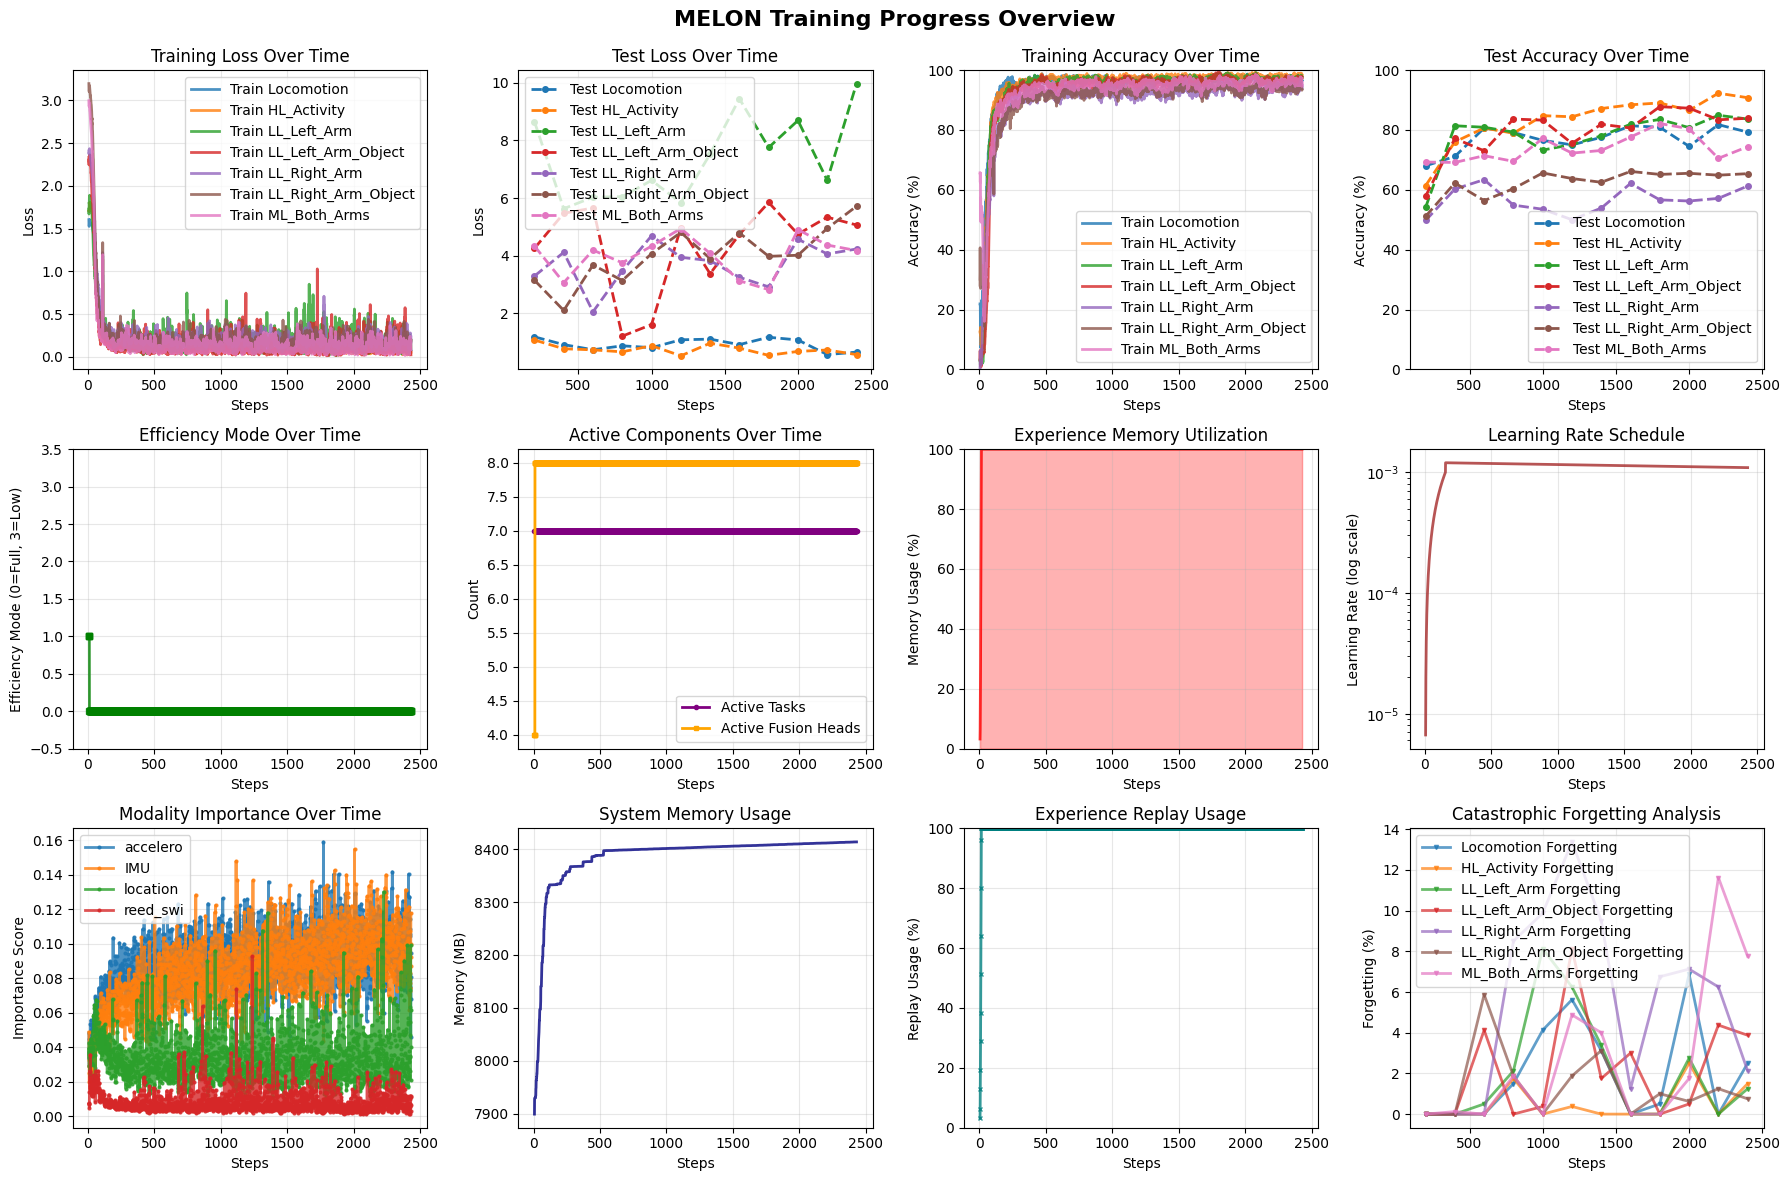

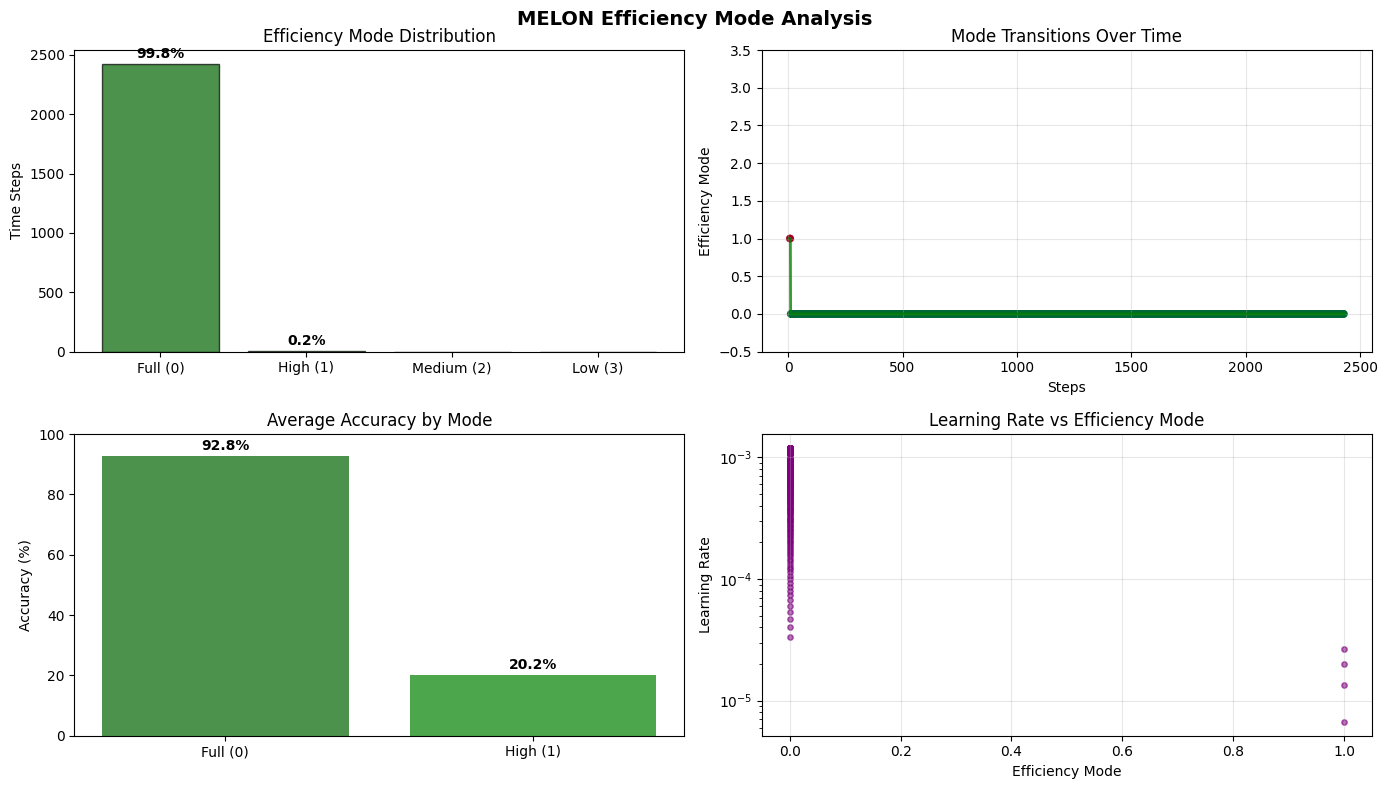

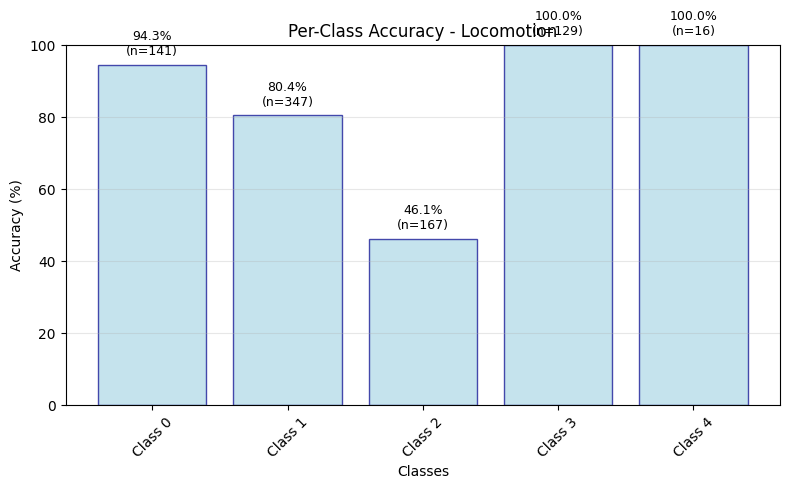


Detailed Classification Report - Locomotion:
              precision    recall  f1-score   support

     Class 0      0.756     0.943     0.839       141
     Class 1      0.811     0.804     0.808       347
     Class 2      0.694     0.461     0.554       167
     Class 3      0.884     1.000     0.938       129
     Class 4      0.696     1.000     0.821        16

    accuracy                          0.792       800
   macro avg      0.768     0.842     0.792       800
weighted avg      0.786     0.792     0.781       800



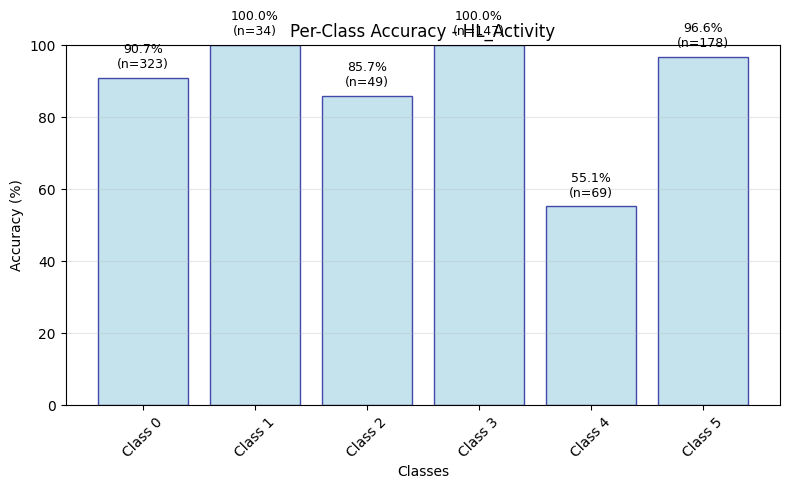


Detailed Classification Report - HL_Activity:
              precision    recall  f1-score   support

     Class 0      0.939     0.907     0.923       323
     Class 1      1.000     1.000     1.000        34
     Class 2      0.792     0.857     0.824        49
     Class 3      0.942     1.000     0.970       147
     Class 4      0.844     0.551     0.667        69
     Class 5      0.860     0.966     0.910       178

    accuracy                          0.907       800
   macro avg      0.896     0.880     0.882       800
weighted avg      0.908     0.907     0.904       800



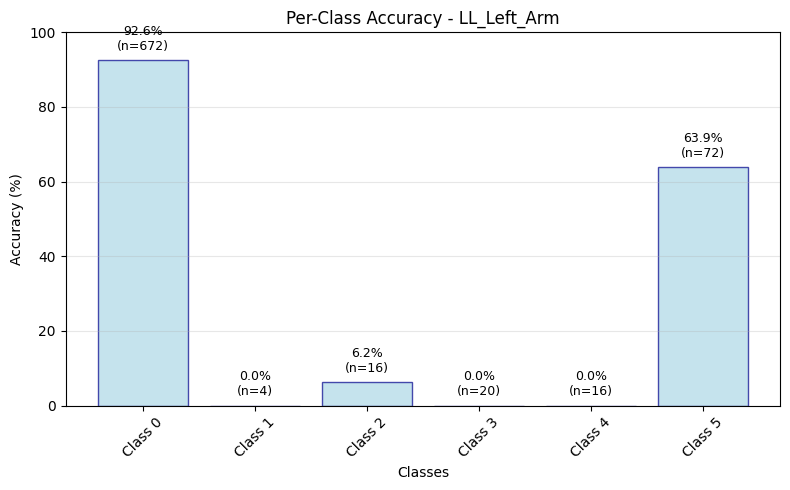


Detailed Classification Report - LL_Left_Arm:
              precision    recall  f1-score   support

     Class 0      0.935     0.926     0.930       672
     Class 1      0.000     0.000     0.000         4
     Class 2      0.053     0.062     0.057        16
     Class 3      0.000     0.000     0.000        20
     Class 4      0.000     0.000     0.000        16
     Class 5      0.474     0.639     0.544        72

    accuracy                          0.836       800
   macro avg      0.244     0.271     0.255       800
weighted avg      0.829     0.836     0.832       800



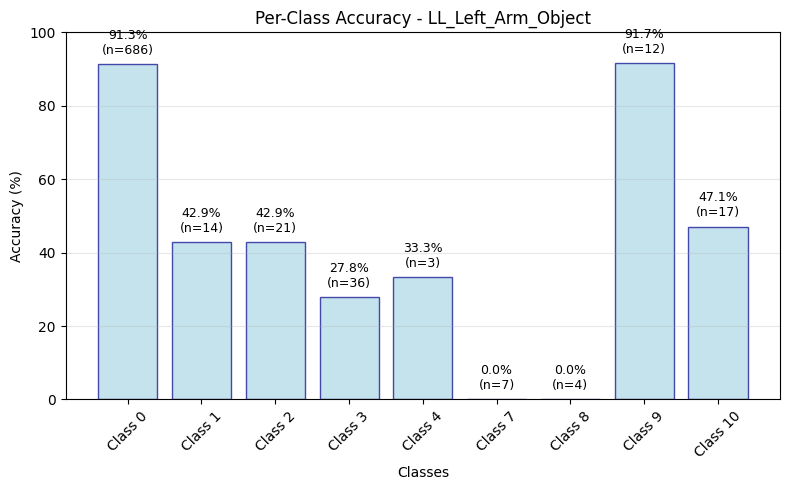


Detailed Classification Report - LL_Left_Arm_Object:
              precision    recall  f1-score   support

     Class 0      0.932     0.913     0.922       686
     Class 1      0.286     0.429     0.343        14
     Class 2      0.562     0.429     0.486        21
     Class 3      0.345     0.278     0.308        36
     Class 4      0.167     0.333     0.222         3
     Class 5      0.000     0.000     0.000         0
     Class 6      0.000     0.000     0.000         0
     Class 7      0.000     0.000     0.000         7
     Class 8      0.000     0.000     0.000         4
     Class 9      0.579     0.917     0.710        12
    Class 10      1.000     0.471     0.640        17

    accuracy                          0.839       800
   macro avg      0.352     0.343     0.330       800
weighted avg      0.865     0.839     0.848       800



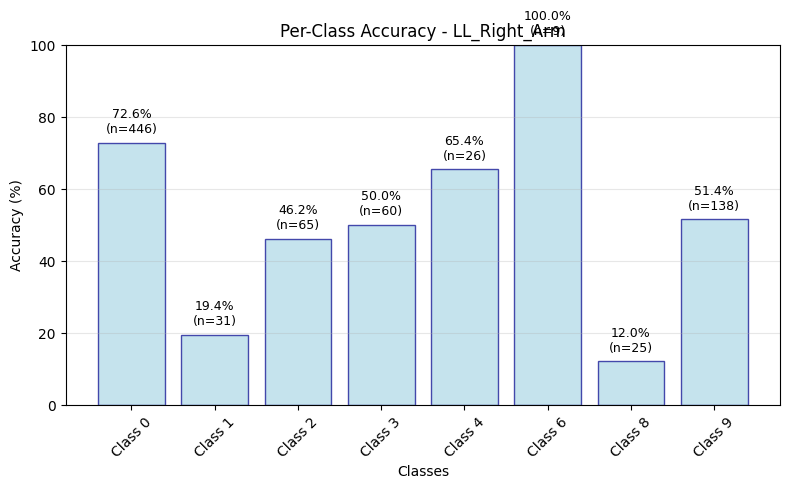


Detailed Classification Report - LL_Right_Arm:
              precision    recall  f1-score   support

     Class 0      0.806     0.726     0.764       446
     Class 1      0.353     0.194     0.250        31
     Class 2      0.297     0.462     0.361        65
     Class 3      0.588     0.500     0.541        60
     Class 4      0.567     0.654     0.607        26
     Class 5      0.000     0.000     0.000         0
     Class 6      0.300     1.000     0.462         9
     Class 8      0.136     0.120     0.128        25
     Class 9      0.534     0.514     0.524       138

    accuracy                          0.613       800
   macro avg      0.398     0.463     0.404       800
weighted avg      0.649     0.613     0.625       800



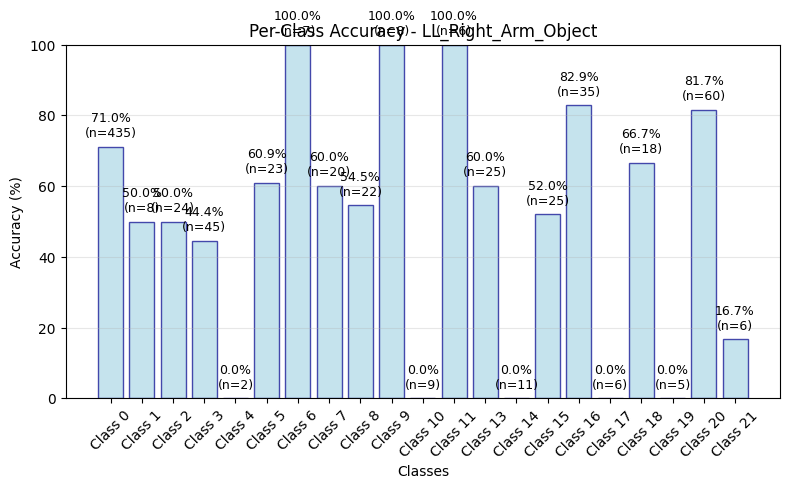


Detailed Classification Report - LL_Right_Arm_Object:
              precision    recall  f1-score   support

     Class 0      0.856     0.710     0.776       435
     Class 1      0.250     0.500     0.333         8
     Class 2      0.364     0.500     0.421        24
     Class 3      0.526     0.444     0.482        45
     Class 4      0.000     0.000     0.000         2
     Class 5      0.538     0.609     0.571        23
     Class 6      0.259     1.000     0.412         7
     Class 7      0.857     0.600     0.706        20
     Class 8      0.923     0.545     0.686        22
     Class 9      0.615     1.000     0.762         8
    Class 10      0.000     0.000     0.000         9
    Class 11      0.250     1.000     0.400         6
    Class 12      0.000     0.000     0.000         0
    Class 13      0.625     0.600     0.612        25
    Class 14      0.000     0.000     0.000        11
    Class 15      0.867     0.520     0.650        25
    Class 16      0.468   

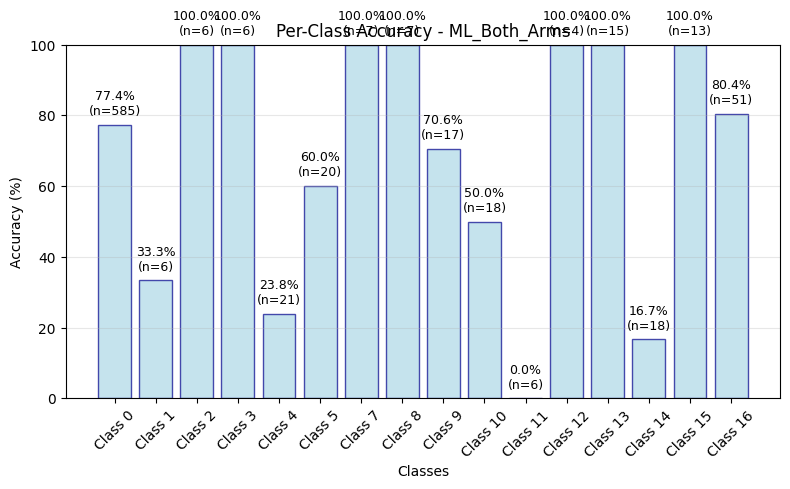


Detailed Classification Report - ML_Both_Arms:
              precision    recall  f1-score   support

     Class 0      0.940     0.774     0.849       585
     Class 1      0.200     0.333     0.250         6
     Class 2      0.857     1.000     0.923         6
     Class 3      0.500     1.000     0.667         6
     Class 4      1.000     0.238     0.385        21
     Class 5      0.364     0.600     0.453        20
     Class 6      0.000     0.000     0.000         0
     Class 7      0.350     1.000     0.519         7
     Class 8      0.269     1.000     0.424         7
     Class 9      0.545     0.706     0.615        17
    Class 10      1.000     0.500     0.667        18
    Class 11      0.000     0.000     0.000         6
    Class 12      0.667     1.000     0.800         4
    Class 13      0.536     1.000     0.698        15
    Class 14      1.000     0.167     0.286        18
    Class 15      0.591     1.000     0.743        13
    Class 16      0.569     0.804

In [7]:
# First, convert your labels to mapped indices for training
train_labels_dict = {}
test_labels_dict = {}
for i, track in enumerate(label_tracks):
    train_labels_dict[track] = torch.from_numpy(train_y[:, i])
    test_labels_dict[track] = torch.from_numpy(test_y[:, i])

# Convert to mapped indices (0-based) for training
mapped_train_labels = model.map_labels_to_indices(train_labels_dict)
mapped_test_labels = model.map_labels_to_indices(test_labels_dict)

# Convert back to numpy dicts (not stacked arrays!)
# Keep tensors (no .numpy())
mapped_train_y = {
    track: mapped_train_labels[track]
    for track in label_tracks
}
mapped_test_y = {
    track: mapped_test_labels[track]
    for track in label_tracks
}

metrics_tracker, final_stats = train_melon_adaptive(
    model,
    train_X_mod,
    mapped_train_y,
    test_X_mod=test_X_mod,
    test_y_dict=mapped_test_y,
    total_steps=total_steps,
    base_lr=1e-3,
    device="cuda" if torch.cuda.is_available() else "cpu",
    window_size=100,
    batch_size=32,
    stream_rate=5,
    print_every=25,
    eval_every=200,
    patience=total_steps,
)

print("Training finished ✅")
print("Final stats:", final_stats)


In [8]:
print(type(train_y))
print(type(test_y))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [9]:
def unified_model_stats(model, count_dense_as_active=False):
    """
    Returns a normalized stats dict with keys:
      total_parameters, active_parameters, current_sparsity,
      estimated_flops, memory_full_mb, memory_active_mb,
      active_tasks, active_attention_heads
    Prefers the model's own get_model_stats(); falls back safely.
    """
    base = {}
    if hasattr(model, "get_model_stats"):
        try:
            base = model.get_model_stats() or {}
        except Exception:
            base = {}

    # 1) Pull from model's stats if available
    total_params = base.get("total_parameters", base.get("total_params"))
    active_params = base.get("active_parameters", base.get("active_params"))
    eff_sparsity = base.get("current_sparsity", base.get("effective_sparsity"))
    est_flops = base.get("estimated_flops")

    # 2) Fallbacks
    if total_params is None:
        total_params = sum(p.numel() for p in model.parameters())

    if active_params is None:
        # Sum masks for DynamicSparseLinear
        active_params = 0
        for m in model.modules():
            if m.__class__.__name__ == "DynamicSparseLinear":
                # mask has same shape as weight
                active_params += int(getattr(m, "mask").sum().item())
            elif count_dense_as_active:
                # Optionally treat non-sparse layers as fully active
                for p in m.parameters(recurse=False):
                    active_params += p.numel()

    if eff_sparsity is None:
        eff_sparsity = 1.0 - (active_params / max(1, total_params))

    if est_flops is None:
        # Reasonable proxy when not provided
        est_flops = active_params

    # 3) Memory estimates using actual dtype size
    try:
        elem_size = next(model.parameters()).element_size()
    except StopIteration:
        elem_size = 4  # default to float32
    memory_full_mb = total_params * elem_size / (1024**2)
    memory_active_mb = active_params * elem_size / (1024**2)

    # 4) Extras
    active_tasks = base.get("active_tasks", getattr(getattr(model, "classifier", None), "active_tasks", None))
    active_attention_heads = base.get("active_attention_heads", getattr(getattr(model, "fusion", None), "active_heads", None))

    return {
        "total_parameters": int(total_params),
        "active_parameters": int(active_params),
        "current_sparsity": float(eff_sparsity),
        "estimated_flops": float(est_flops),
        "memory_full_mb": float(memory_full_mb),
        "memory_active_mb": float(memory_active_mb),
        "active_tasks": active_tasks,
        "active_attention_heads": active_attention_heads,
    }

In [10]:


stats = unified_model_stats(model)  # default: counts only masked params as active

print(f"Total parameters: {stats['total_parameters']}")
print(f"Active parameters: {stats['active_parameters']}")
print(f"Sparsity: {stats['current_sparsity']:.4f}")
print(f"Estimated FLOPs: {stats['estimated_flops']}")
print(f"Memory (full): {stats['memory_full_mb']:.2f} MB")
print(f"Memory (active): {stats['memory_active_mb']:.2f} MB")
print(f"Active tasks: {stats['active_tasks']}")
print(f"Active attention heads: {stats['active_attention_heads']}")



Total parameters: 205123
Active parameters: 0
Sparsity: 1.0000
Estimated FLOPs: 0.0
Memory (full): 0.78 MB
Memory (active): 0.00 MB
Active tasks: ['Locomotion', 'HL_Activity', 'LL_Left_Arm', 'LL_Left_Arm_Object', 'LL_Right_Arm', 'LL_Right_Arm_Object', 'ML_Both_Arms']
Active attention heads: None


In [11]:
import torch
import json

def save_adaptive_model(model, filepath_prefix: str = "melon_model"):
    """Quick fix version - just saves weights and basic stats"""
    
    # Save weights
    torch.save(model.state_dict(), f"{filepath_prefix}_state.pth")
    
    # Get stats and convert to JSON-safe format
    stats = model.get_model_stats()
    safe_stats = {}
    
    for key, value in stats.items():
        try:
            # Try to serialize
            json.dumps(value)
            safe_stats[key] = value
        except (TypeError, ValueError):
            # If it fails, convert to string
            safe_stats[key] = str(value)
    
    # Save stats
    with open(f"{filepath_prefix}_stats.json", "w") as f:
        json.dump(safe_stats, f, indent=4)
    
    print(f"✅ Model saved: {filepath_prefix}_state.pth & {filepath_prefix}_stats.json")

# Use it
save_adaptive_model(model)

✅ Model saved: melon_model_state.pth & melon_model_stats.json
